* https://www.kaggle.com/aless80/sarimax-on-mean-visits

* https://www.kaggle.com/headsortails/be-my-guest-recruit-restaurant-eda

* https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/

*  https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3  (Tal cual practicas de Time Series)

* https://www.kdnuggets.com/2018/03/time-series-dummies-3-step-process.html

* Agregar TSFresh

# IDEAS / ANOTACIONES

**MODELOS A PROBAR**

* Exponential Smoothing
* AR1
* ARIMAX
* Prophet
* XGBoost

**Puntos/Ideas a considerar o agregar**
* **Done** Flag de missings para AIR Reservations --> puse una flag desde que cae hasta que sube, no necesariamente que sea 0.
*  **Done** Agregar indicador de cantidad de restaurants en la misma zona
* **Done** Exploratorio de fechas de 1era reserva en el sistema por restaurant
* **Done** Incorporar informacion del clima para ver si influye en las reservas
*  Histograma de Tlag (Antelacion de reservas) vs Freq (para ver cuan anticipadas son las reservas)
*  Agregar indicadores para levantar datos de HPG Reservations (por dia, considerar tipo de comida y zona/ciudad)
* Exploratorio de reservas segun dia de la semana/mes
* Agrgar lo mismo para HPG y lo mismo con la suma de ambos.

https://facebook.github.io/prophet/docs/quick_start.html#python-api


https://tsfresh.readthedocs.io/en/latest/text/forecasting.html

http://www.statsmodels.org/stable/vector_ar.html

https://www.statsmodels.org/dev/generated/statsmodels.tsa.kalmanf.kalmanfilter.KalmanFilter.html

#0.Referencias

Recruit Holdings has unique access to key datasets that could make automated future customer prediction possible. Specifically, Recruit Holdings owns Hot Pepper Gourmet (a restaurant review service), AirREGI (a restaurant point of sales service), and Restaurant Board (reservation log management software).

In this competition, you're challenged to use reservation and visitation data to predict the total number of visitors to a restaurant for future dates. This information will help restaurants be much more efficient and allow them to focus on creating an enjoyable dining experience for their customers.

**Links útiles**


*   https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting
*   Elemento de la lista



**Sistemas de reservas**
* **Hot Pepper Gourmet (hpg)**: similar to Yelp, here users can search restaurants and also make a reservation online

* **AirREGI / Restaurant Board (air)**: similar to Square, a reservation control and cash register system

**Archivos de datos**
* **air_visit_data.csv**: historical visit data for the air restaurants. This is essentially the main training data set.

* **air_reserve.csv / hpg_reserve.csv**: reservations made through the air / hpg systems.

* **air_store_info.csv / hpg_store_info.csv**: details about the air / hpg restaurants including genre and location.

* **store_id_relation.csv**: connects the air and hpg ids

* **date_info.csv**: essentially flags the Japanese holidays.

* **sample_submission.csv**: serves as the test set. The id is formed by combining the air id with the visit date.

# 1.Importación & Extracción

In [1]:
!pip install prettytable
!pip install fbprophet
# !pip install tsfresh
!pip install sklearn-deap
!pip install tqdm

###!apt install proj-bin libproj-dev libgeos-dev
###!pip install https://github.com/matplotlib/basemap/archive/v1.1.0.tar.gz

    100% |████████████████████████████████| 942kB 20.7MB/s 
  Running setup.py bdist_wheel for sklearn-deap ... - done
  Stored in directory: /root/.cache/pip/wheels/7f/e8/b9/5d5ccd81a3f56cd64a6edfdcd990a51b8db5e02d657e19df80
  Running setup.py bdist_wheel for deap ... - \ | / - \ | done
  Stored in directory: /root/.cache/pip/wheels/22/ea/bf/dc7c8a2262025a0ab5da9ef02282c198be88902791ca0c6658
Successfully built sklearn-deap deap


In [0]:
import numpy as np
import pandas as pd

#Visualization libs
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
from sklearn.linear_model import LinearRegression

from datetime import datetime
import calendar
from prettytable import PrettyTable
from tqdm import tqdm

In [0]:
#Propiedades generales
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 50)

#Deshabilito warning Chained Assigment
pd.options.mode.chained_assignment = None

In [706]:
#Se instala para cada sesión
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Autentica y el crea el cliente Py
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Obtengo el contenido del archivo
archivos = {
    'air_visit_data.csv'    : ['1GzPP7pk6csKcfHr_jm5wIKp3Jx2DZv5j', 'air_visit',   ['visit_date']],   # TRAIN / AIR-Visitantes
    'air_store_info.csv'    : ['1GGz4A9JDJkLYujsnU2jPsfrK8x9LlmTF', 'air_st',      []],      # TRAIN / AIR-Info
    'air_reserve.csv'       : ['17zRgupPi6UqxFHyZl7rCMUP0IiMgMLqf', 'air_res',     ['visit_datetime','reserve_datetime']],     # TRAIN / AIR-Reservas
    'hpg_store_info.csv'    : ['1t6daiSnmIgV2IJIigFF9ZxyE0OBQlj0A', 'hpg_st',      []],      # HPG-Info
    'hpg_reserve.csv'       : ['11ibFnYbeB3UICG_EvVP9i3nZ52L4fx-k', 'hpg_res',     ['visit_datetime','reserve_datetime']],     # HPG-Reservas
    'store_id_relation.csv' : ['188ST4q68UscmkrO-IGP0fd_vwUsLkKg4', 'store_rel',   []],   # AIR-HPG
    'sample_submission.csv' : ['1994F5OoeBUznh3X_sX-ccRmVrPt3a9f7', 'sample_sub',  []],  # TEST / Store-Fecha-Visitantes
    'date_info.csv'         : ['1ge_cmSCB9WtbKgWXnGZe7cFgLLmBtRrQ', 'date_info',   ['calendar_date'] ],   # Feriados
    'WeatherData.csv'       : ['1OWrFnLkibFtyTJ2W2urNePqi4hOhvJQR', 'WeatherData', []], # Información adicional - Clima
    'area_name_mapping.csv' : ['14ePuU6xUCJMGV-0_sSaqKN3bONqL0Xx3', 'area_name',   []],   # Información adicional - Ciudades
}

t = PrettyTable(['Archivo', 'df', 'Filas', 'Columnas'])

for f in archivos:
    json_import = drive.CreateFile({'id':archivos[f][0]}) #El ID único del archivo en cuestión
    json_import.GetContentFile(f)
    v=archivos[f][1]
    locals()[v] = pd.read_csv(f, parse_dates = archivos[f][2])
    t.add_row( [ f , v, eval(v).shape[0], eval(v).shape[1] ] ) 
    
print(t)

+-----------------------+-------------+---------+----------+
|        Archivo        |      df     |  Filas  | Columnas |
+-----------------------+-------------+---------+----------+
|   air_visit_data.csv  |  air_visit  |  252108 |    3     |
|   air_store_info.csv  |    air_st   |   829   |    5     |
|    air_reserve.csv    |   air_res   |  92378  |    4     |
|   hpg_store_info.csv  |    hpg_st   |   4690  |    5     |
|    hpg_reserve.csv    |   hpg_res   | 2000320 |    4     |
| store_id_relation.csv |  store_rel  |   150   |    2     |
| sample_submission.csv |  sample_sub |  32019  |    2     |
|     date_info.csv     |  date_info  |   517   |    3     |
|    WeatherData.csv    | WeatherData |  33088  |    16    |
| area_name_mapping.csv |  area_name  |   103   |    2     |
+-----------------------+-------------+---------+----------+


# 2.Análisis Exploratorio

In [0]:
def explorar( df ):
  print( 'Tamaño: ', df.shape)
  
  t = PrettyTable(['Atributo', 'Tipo de Dato', 'Nulos', 'Unique'])
  for c in df.columns:
    t.add_row( [c, df[c].dtype, np.sum(df[c].isna() ) , np.count_nonzero (df[c].unique() ) ] ) 
  print (t)
  print ()
  return df.head()

##2.a) AIR

In [313]:
explorar( air_visit )

Tamaño:  (252108, 3)
+--------------+----------------+-------+--------+
|   Atributo   |  Tipo de Dato  | Nulos | Unique |
+--------------+----------------+-------+--------+
| air_store_id |     object     |   0   |  829   |
|  visit_date  | datetime64[ns] |   0   |  478   |
|   visitors   |     int64      |   0   |  204   |
+--------------+----------------+-------+--------+



,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [314]:
states = air_st.air_area_name.str.split(' ', expand = True)
air_st['air_store_by_area_count'] = air_st.air_area_name.apply(lambda x: air_st[air_st.air_area_name == x]['air_store_id'].count() )

#Prefecturas de Japón. Se referncian como estados.
air_st['state_name']    = states[0].fillna('')
air_st['city_name']     = states[0].fillna('') + ' ' + states[1].fillna('')

explorar( air_st )

Tamaño:  (829, 8)
+-------------------------+--------------+-------+--------+
|         Atributo        | Tipo de Dato | Nulos | Unique |
+-------------------------+--------------+-------+--------+
|       air_store_id      |    object    |   0   |  829   |
|      air_genre_name     |    object    |   0   |   14   |
|      air_area_name      |    object    |   0   |  103   |
|         latitude        |   float64    |   0   |  108   |
|        longitude        |   float64    |   0   |  108   |
| air_store_by_area_count |    int64     |   0   |   26   |
|        state_name       |    object    |   0   |   9    |
|        city_name        |    object    |   0   |   55   |
+-------------------------+--------------+-------+--------+



,air_store_id,air_genre_name,air_area_name,latitude,longitude,air_store_by_area_count,state_name,city_name
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695,135.198,17,Hyōgo-ken,Hyōgo-ken Kōbe-shi
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695,135.198,17,Hyōgo-ken,Hyōgo-ken Kōbe-shi
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695,135.198,17,Hyōgo-ken,Hyōgo-ken Kōbe-shi
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695,135.198,17,Hyōgo-ken,Hyōgo-ken Kōbe-shi
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658,139.752,51,Tōkyō-to,Tōkyō-to Minato-ku


In [0]:
explorar( air_res )

Tamaño:  (92378, 4)
+------------------+----------------+-------+--------+
|     Atributo     |  Tipo de Dato  | Nulos | Unique |
+------------------+----------------+-------+--------+
|   air_store_id   |     object     |   0   |  314   |
|  visit_datetime  | datetime64[ns] |   0   |  4975  |
| reserve_datetime | datetime64[ns] |   0   |  7513  |
| reserve_visitors |     int64      |   0   |   71   |
+------------------+----------------+-------+--------+



,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [0]:
air_res['visit_date'] = air_res['visit_datetime'].apply(lambda x: x.date()).astype('datetime64')
air_res['reserve_date'] = air_res['reserve_datetime'].apply(lambda x: x.date()).astype('datetime64')

explorar( air_res )

/usr/local/lib/python3.6/dist-packages/pandas/core/internals.py:3462: FutureWarning: Passing in 'datetime64' dtype with no frequency is deprecated and will raise in a future version. Please pass in 'datetime64[ns]' instead.
  return self.apply('astype', dtype=dtype, **kwargs)


Tamaño:  (92378, 6)
+------------------+----------------+-------+--------+
|     Atributo     |  Tipo de Dato  | Nulos | Unique |
+------------------+----------------+-------+--------+
|   air_store_id   |     object     |   0   |  314   |
|  visit_datetime  | datetime64[ns] |   0   |  4975  |
| reserve_datetime | datetime64[ns] |   0   |  7513  |
| reserve_visitors |     int64      |   0   |   71   |
|    visit_date    | datetime64[ns] |   0   |  433   |
|   reserve_date   | datetime64[ns] |   0   |  477   |
+------------------+----------------+-------+--------+



,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,reserve_date
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,2016-01-01
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,2016-01-01
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,2016-01-01
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,2016-01-01,2016-01-01
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,2016-01-01,2016-01-01


## 2.b) HPG

In [0]:
explorar( hpg_st )

Tamaño:  (4690, 5)
+----------------+--------------+-------+--------+
|    Atributo    | Tipo de Dato | Nulos | Unique |
+----------------+--------------+-------+--------+
|  hpg_store_id  |    object    |   0   |  4690  |
| hpg_genre_name |    object    |   0   |   34   |
| hpg_area_name  |    object    |   0   |  119   |
|    latitude    |   float64    |   0   |  129   |
|   longitude    |   float64    |   0   |  129   |
+----------------+--------------+-------+--------+



,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.644,139.668
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.644,139.668
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.644,139.668
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.644,139.668
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.644,139.668


In [0]:
explorar( hpg_res )

Tamaño:  (2000320, 4)
+------------------+----------------+-------+--------+
|     Atributo     |  Tipo de Dato  | Nulos | Unique |
+------------------+----------------+-------+--------+
|   hpg_store_id   |     object     |   0   | 13325  |
|  visit_datetime  | datetime64[ns] |   0   |  9847  |
| reserve_datetime | datetime64[ns] |   0   | 11450  |
| reserve_visitors |     int64      |   0   |   99   |
+------------------+----------------+-------+--------+



,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [0]:
hpg_res['visit_date']   = hpg_res['visit_datetime'].apply(lambda x: x.date() ).astype('datetime64')
hpg_res['reserve_date'] = hpg_res['reserve_datetime'].apply(lambda x: x.date() ).astype('datetime64')

explorar( hpg_res )

/usr/local/lib/python3.6/dist-packages/pandas/core/internals.py:3462: FutureWarning: Passing in 'datetime64' dtype with no frequency is deprecated and will raise in a future version. Please pass in 'datetime64[ns]' instead.
  return self.apply('astype', dtype=dtype, **kwargs)


Tamaño:  (2000320, 6)
+------------------+----------------+-------+--------+
|     Atributo     |  Tipo de Dato  | Nulos | Unique |
+------------------+----------------+-------+--------+
|   hpg_store_id   |     object     |   0   | 13325  |
|  visit_datetime  | datetime64[ns] |   0   |  9847  |
| reserve_datetime | datetime64[ns] |   0   | 11450  |
| reserve_visitors |     int64      |   0   |   99   |
|    visit_date    | datetime64[ns] |   0   |  517   |
|   reserve_date   | datetime64[ns] |   0   |  478   |
+------------------+----------------+-------+--------+



,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,reserve_date
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,2016-01-01,2016-01-01
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2016-01-01,2016-01-01
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2,2016-01-01,2016-01-01
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5,2016-01-01,2016-01-01
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13,2016-01-01,2016-01-01


Eliminamos las reservas relacionadas únicamente con el sistema HPG (sin relación con AIR) por su poca utilidad para el caso. Se guarda el un DF auxiliar para futuros usos.

In [0]:
#Se eliminan las reservas que solo tienen HPG
if not(hpg_res.columns.contains('air_store_id')):
  hpg_res_raw = hpg_res
  hpg_res = pd.merge(hpg_res, store_rel, how='inner', on=['hpg_store_id'])

explorar( hpg_res )

Tamaño:  (28183, 7)
+------------------+----------------+-------+--------+
|     Atributo     |  Tipo de Dato  | Nulos | Unique |
+------------------+----------------+-------+--------+
|   hpg_store_id   |     object     |   0   |  150   |
|  visit_datetime  | datetime64[ns] |   0   |  3805  |
| reserve_datetime | datetime64[ns] |   0   |  8470  |
| reserve_visitors |     int64      |   0   |   58   |
|    visit_date    | datetime64[ns] |   0   |  508   |
|   reserve_date   | datetime64[ns] |   0   |  478   |
|   air_store_id   |     object     |   0   |  150   |
+------------------+----------------+-------+--------+



,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,reserve_date,air_store_id
0,hpg_878cc70b1abc76f7,2016-01-01 19:00:00,2016-01-01 15:00:00,4,2016-01-01,2016-01-01,air_db80363d35f10926
1,hpg_878cc70b1abc76f7,2016-01-02 19:00:00,2016-01-02 14:00:00,2,2016-01-02,2016-01-02,air_db80363d35f10926
2,hpg_878cc70b1abc76f7,2016-01-03 18:00:00,2016-01-02 20:00:00,6,2016-01-03,2016-01-02,air_db80363d35f10926
3,hpg_878cc70b1abc76f7,2016-01-06 20:00:00,2016-01-04 22:00:00,3,2016-01-06,2016-01-04,air_db80363d35f10926
4,hpg_878cc70b1abc76f7,2016-01-11 18:00:00,2016-01-11 14:00:00,2,2016-01-11,2016-01-11,air_db80363d35f10926


## 2.c) Relación AIR-HPG

In [0]:
explorar( store_rel )

Tamaño:  (150, 2)
+--------------+--------------+-------+--------+
|   Atributo   | Tipo de Dato | Nulos | Unique |
+--------------+--------------+-------+--------+
| air_store_id |    object    |   0   |  150   |
| hpg_store_id |    object    |   0   |  150   |
+--------------+--------------+-------+--------+



,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


## 2.d) Sample Submission

El Sample Submission es el archivo que tiene que surgir como output del desafío, indicando por restaurante (solo de AIR) y fecha la cantidad de visitantes predichos por el modelo.
No contiene datos reales, son 100% 0.

In [0]:
if sample_sub.columns.contains('id'):
  sample_sub['date'] = sample_sub.id.str.split('_' , expand = True).iloc[:, 2]
  sample_sub['air_store_id'] = sample_sub.id.str.split('_' , expand = True).iloc[:, 0] + '_' + sample_sub.id.str.split('_' , expand = True).iloc[:, 1]
  sample_sub.drop(columns = 'id' , inplace = True)

sample_sub = sample_sub.loc[:,['air_store_id', 'date', 'visitors']]

explorar( sample_sub ) 

Tamaño:  (32019, 3)
+--------------+--------------+-------+--------+
|   Atributo   | Tipo de Dato | Nulos | Unique |
+--------------+--------------+-------+--------+
| air_store_id |    object    |   0   |  821   |
|     date     |    object    |   0   |   39   |
|   visitors   |    int64     |   0   |   0    |
+--------------+--------------+-------+--------+



,air_store_id,date,visitors
0,air_00a91d42b08b08d9,2017-04-23,0
1,air_00a91d42b08b08d9,2017-04-24,0
2,air_00a91d42b08b08d9,2017-04-25,0
3,air_00a91d42b08b08d9,2017-04-26,0
4,air_00a91d42b08b08d9,2017-04-27,0


## 2.e) Feriados

In [0]:
explorar(date_info)

Tamaño:  (517, 3)
+---------------+----------------+-------+--------+
|    Atributo   |  Tipo de Dato  | Nulos | Unique |
+---------------+----------------+-------+--------+
| calendar_date | datetime64[ns] |   0   |  517   |
|  day_of_week  |     object     |   0   |   7    |
|  holiday_flg  |     int64      |   0   |   1    |
+---------------+----------------+-------+--------+



,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


## 2.f) Adicionales

In [0]:
explorar(WeatherData)

Tamaño:  (33088, 16)
+--------------------+--------------+-------+--------+
|      Atributo      | Tipo de Dato | Nulos | Unique |
+--------------------+--------------+-------+--------+
|     area_name      |    object    |   0   |   64   |
|   calendar_date    |    object    |   0   |  517   |
|   precipitation    |   float64    |  3623 |  258   |
|  avg_temperature   |   float64    |  4152 |  475   |
|   total_snowfall   |   float64    | 28911 |   39   |
|  deepest_snowfall  |   float64    | 28404 |  128   |
|   hours_sunlight   |   float64    |  7265 |  148   |
|   avg_wind_speed   |   float64    |  4245 |  120   |
| avg_vapor_pressure |   float64    | 23282 |  312   |
|    avg_humidity    |   float64    | 23282 |   76   |
|  avg_sea_pressure  |   float64    | 23265 |  397   |
| avg_local_pressure |   float64    | 23265 |  472   |
|  solar_radiation   |   float64    | 26884 |  2477  |
|    cloud_cover     |   float64    | 25850 |   51   |
|  high_temperature  |   float64    |  4152 

,area_name,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature
0,fukuoka_dazaifu-kana_dasaif,1/1/16,0.000,5.700,nan,nan,5.100,1.900,nan,nan,nan,nan,nan,nan,11.000,2.100
1,fukuoka_dazaifu-kana_dasaif,1/2/16,0.500,10.200,nan,nan,1.300,2.200,nan,nan,nan,nan,nan,nan,15.300,6.100
2,fukuoka_dazaifu-kana_dasaif,1/3/16,0.000,11.200,nan,nan,0.500,0.900,nan,nan,nan,nan,nan,nan,15.500,7.100
3,fukuoka_dazaifu-kana_dasaif,1/4/16,0.000,9.400,nan,nan,4.200,1.800,nan,nan,nan,nan,nan,nan,16.100,5.900
4,fukuoka_dazaifu-kana_dasaif,1/5/16,1.500,8.800,nan,nan,0.000,0.800,nan,nan,nan,nan,nan,nan,12.300,7.100


In [0]:
explorar(area_name)

Tamaño:  (103, 2)
+---------------+--------------+-------+--------+
|    Atributo   | Tipo de Dato | Nulos | Unique |
+---------------+--------------+-------+--------+
| air_area_name |    object    |   0   |  103   |
|   station_id  |    object    |   0   |   38   |
+---------------+--------------+-------+--------+



,air_area_name,station_id
0,Hyōgo-ken Kōbe-shi Kumoidōri,hyogo__kobe-kana__koube
1,Tōkyō-to Minato-ku Shibakōen,tokyo__tokyo-kana__tonokyo
2,Fukuoka-ken Fukuoka-shi Daimyō,fukuoka__fukuoka-kana__fukuoka
3,Tōkyō-to Setagaya-ku Setagaya,tokyo__setagaya-kana__setagaya
4,Ōsaka-fu Ōsaka-shi Ōgimachi,osaka__osaka-kana__osaka


In [0]:
weather = pd.merge(WeatherData, area_name, how='inner', left_on = 'area_name', right_on = 'station_id' )
weather = weather.drop(columns = ['station_id', 'area_name'] )
weather.calendar_date = pd.to_datetime(weather.calendar_date , dayfirst = True)
weather.fillna(0 , inplace = True)
explorar(weather)

Tamaño:  (53251, 16)
+--------------------+----------------+-------+--------+
|      Atributo      |  Tipo de Dato  | Nulos | Unique |
+--------------------+----------------+-------+--------+
|   calendar_date    | datetime64[ns] |   0   |  517   |
|   precipitation    |    float64     |   0   |  213   |
|  avg_temperature   |    float64     |   0   |  451   |
|   total_snowfall   |    float64     |   0   |   34   |
|  deepest_snowfall  |    float64     |   0   |   93   |
|   hours_sunlight   |    float64     |   0   |  146   |
|   avg_wind_speed   |    float64     |   0   |  110   |
| avg_vapor_pressure |    float64     |   0   |  311   |
|    avg_humidity    |    float64     |   0   |   75   |
|  avg_sea_pressure  |    float64     |   0   |  387   |
| avg_local_pressure |    float64     |   0   |  468   |
|  solar_radiation   |    float64     |   0   |  2402  |
|    cloud_cover     |    float64     |   0   |   50   |
|  high_temperature  |    float64     |   0   |  462   |
|  low_tem

,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature,air_area_name
0,2016-01-01,0.000,7.300,0.000,0.000,6.600,2.100,7.600,76.000,1031.100,1029.200,10.350,4.300,12.600,3.100,Fukuoka-ken Fukuoka-shi Daimyō
1,2016-01-01,0.000,7.300,0.000,0.000,6.600,2.100,7.600,76.000,1031.100,1029.200,10.350,4.300,12.600,3.100,Fukuoka-ken Fukuoka-shi Tenjin
2,2016-01-01,0.000,7.300,0.000,0.000,6.600,2.100,7.600,76.000,1031.100,1029.200,10.350,4.300,12.600,3.100,Fukuoka-ken Fukuoka-shi Takatori
3,2016-01-01,0.000,7.300,0.000,0.000,6.600,2.100,7.600,76.000,1031.100,1029.200,10.350,4.300,12.600,3.100,Fukuoka-ken Fukuoka-shi Torikai
4,2016-01-01,0.000,7.300,0.000,0.000,6.600,2.100,7.600,76.000,1031.100,1029.200,10.350,4.300,12.600,3.100,Fukuoka-ken Fukuoka-shi Momochi


## 2.g) Gráficos

In [0]:
def plot_serie(df, date, serie,
               x_label, y_label, title,
              fecha_desde, fecha_hasta):

  # Compare Reservation data to Visitor data
  #Visitor each day

  plt.figure(figsize=(15, 7))
  plt.plot(date, 
           serie, 
           data = df[(df[date] >= fecha_desde) & (df[date] <= fecha_hasta)]
                  .groupby(date, as_index=False).agg({serie: np.sum}).sort_values( by = date)
          )
  
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.show()

Defino una función que permita comparar dos series en paralelo. El primer argumento es una fecha, el segundo un valor numérico.

In [0]:
#Funcion original

# def series_comparisson(df1, date1, series1, df2, date2, series2, fecha_desde, fecha_hasta, graph1 = 1, graph2 = 1 , title = "" ):
#   plt.figure(figsize=(15, 7))

#   plt.grid(axis = 'y')
#   if graph1 == 1:
#     plt.plot(date1, 
#              series1, 
#              data = df1[( df1[date1] >= fecha_desde) & ( df1[date1]  <= fecha_hasta)]
#                     .groupby( date1, as_index = False ).agg({ series1: np.sum}).sort_values( by = date1 )
#             )
#     plt.legend( [series1], loc = 2)
#     plt.ylabel( series1 + ' [#]')
  
#   plt.xlabel('Dates')
  
#   #Genero un eje paralelo...
#   if graph2 == 1:
#     plt.twinx().plot(date2, 
#                      series2, 
#                      data = df2[( df2[date2] >= fecha_desde) & ( df2[date2]  <= fecha_hasta)]
#                             .groupby( date2, as_index = False ).agg({ series2: np.sum}).sort_values( by = date2 ) , 
#                      color = 'green' 
#                     )
#     plt.ylabel('reservations [#]')

#   plt.title(title)

#   #dibujo una linea que demarque el dia D
#   plt.vlines( np.max( air_visit[(air_visit.visit_date >= fecha_desde) & (air_visit.visit_date <= fecha_hasta)]['visit_date']) , 0 , 5000 , linestyles = 'dashed' )
#   plt.legend([series2, 'D day'], loc = 9, )
#   plt.show();

In [0]:
#Funcion modificada

def series_comparisson(df1, date1, series1, label1,
                       df2, date2, series2, label2,
                       df3, date3, series3, label3,
                       fecha_desde, fecha_hasta,
                       rango_y1=[-10000,25000],rango_y2=[0,14000],
                       graph1 = 0, graph2 = 0 , graph3 = 0, 
                       title = '' ):
  fig = plt.figure(figsize=(15, 7))
  fig.suptitle(title)
  ax1 = fig.add_subplot(111)
  ax1.set_xlabel('Dates')

  
  if graph1 == 1:
    ax1.plot(date1, 
             series1, 
             data = df1[( df1[date1] >= fecha_desde) & ( df1[date1]  <= fecha_hasta)]
             .groupby( date1, as_index = False ).agg({ series1: np.sum}).sort_values( by = date1 ) ,
             color = 'red',
             label=series1 + '_' + str(label1))
    ax1.set_ylim(rango_y1)
    ax1.set_ylabel( series1 + ' [#]')
    ax1.legend(loc=1)
      
  #Genero un eje paralelo...
  if graph2 == 1:
    ax2 = ax1.twinx()
    ax2.plot(date2,
             series2, 
             data = df2[( df2[date2] >= fecha_desde) & ( df2[date2]  <= fecha_hasta)]
             .groupby( date2, as_index = False ).agg({ series2: np.sum}).sort_values( by = date2 ) , 
             color = 'green',
             label=series2 + '_' + str(label2))
    ax2.set_ylim(rango_y2)
    ax2.set_ylabel('reservations [#]')
    ax2.legend(loc=5)
    
  if graph3 == 1:
    ax3=ax2
    ax3.plot(date3,
             series3, 
             data = df3[( df3[date3] >= fecha_desde) & ( df3[date3]  <= fecha_hasta)]
             .groupby( date3, as_index = False ).agg({ series3: np.sum}).sort_values( by = date3 ) , 
             color = 'blue',
             label=series3 + '_' + str(label3))
    ax3.legend(loc=5)


  #dibujo una linea que demarque el dia D
  if graph2 == 1:
    ax2.vlines( np.max( air_visit[(air_visit.visit_date >= fecha_desde) & (air_visit.visit_date <= fecha_hasta)]['visit_date']) ,
               0 , 5000 ,
               linestyles = 'dashed',
               label='D day')
    ax2.legend(loc=5)

  plt.show()

In [0]:
fecha_desde = datetime.strptime( '2016 01 01', '%Y %m %d')
fecha_hasta = datetime.strptime( '2017 12 31', '%Y %m %d')

### I) AIR Reservations

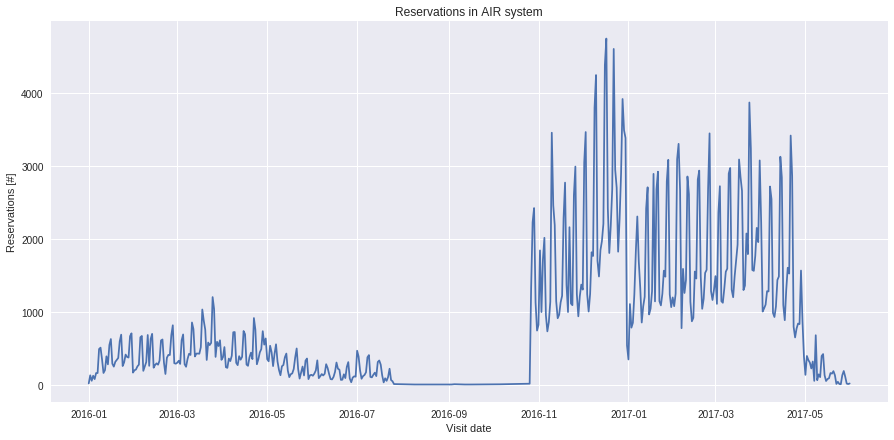

In [0]:
plot_serie(air_res, 'visit_date', 'reserve_visitors',
           'Visit date', 'Reservations [#]', 'Reservations in AIR system',
           fecha_desde, fecha_hasta)

### II) HPG Reservations

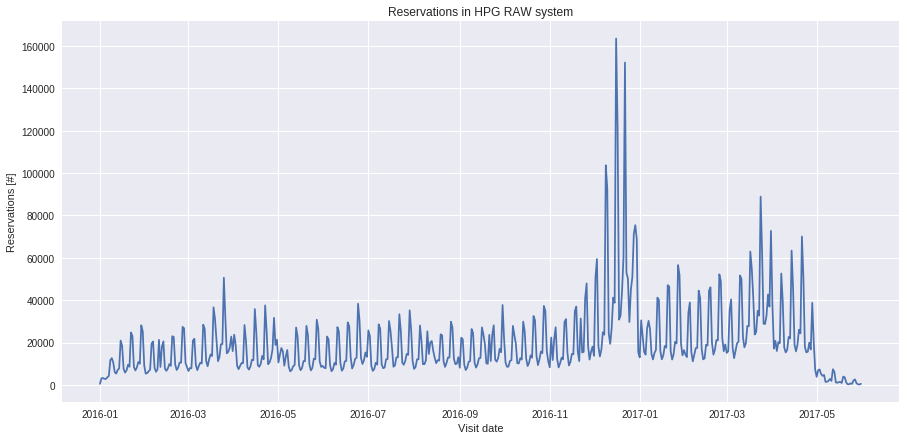

In [0]:
plot_serie(hpg_res_raw, 'visit_date', 'reserve_visitors',
           'Visit date', 'Reservations [#]', 'Reservations in HPG RAW system',
           fecha_desde, fecha_hasta)

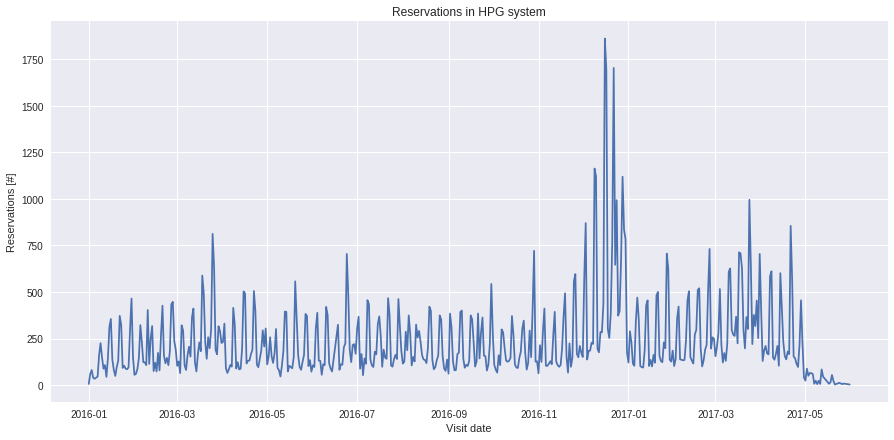

In [0]:
plot_serie(hpg_res, 'visit_date', 'reserve_visitors',
           'Visit date', 'Reservations [#]', 'Reservations in HPG system',
           fecha_desde, fecha_hasta)

### III) AIR Visits

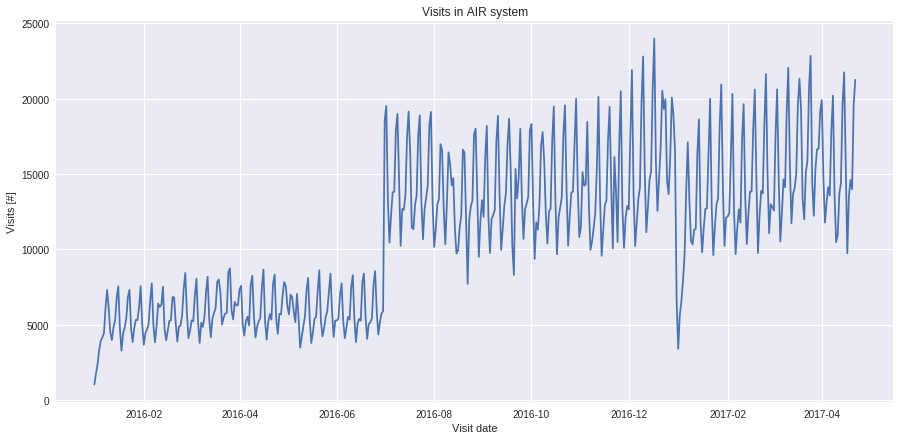

In [0]:
plot_serie(air_visit, 'visit_date', 'visitors',
           'Visit date', 'Visits [#]', 'Visits in AIR system',
           fecha_desde, fecha_hasta)

### IV) AIR & HPG Reservations VS. AIR Visits

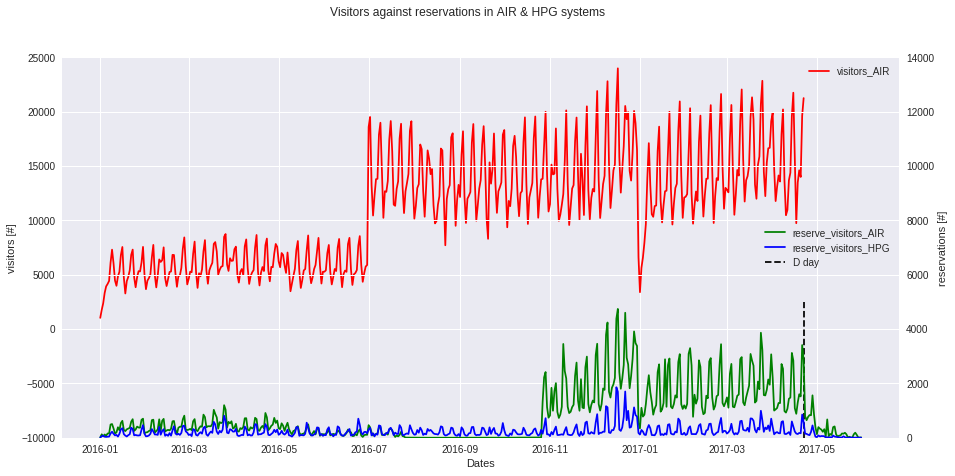

In [0]:
series_comparisson(
    air_visit, 'visit_date', 'visitors', 'AIR',
    air_res, 'visit_date', 'reserve_visitors', 'AIR',
    hpg_res, 'visit_date', 'reserve_visitors', 'HPG',
    fecha_desde, fecha_hasta,
    rango_y1=[-10000,25000],rango_y2=[0,14000],
    graph1 = 1 , graph2 = 1, graph3 = 1,
    title = "Visitors against reservations in AIR & HPG systems"
)

### V) Primera fecha de reserva

In [0]:
#Air System
pd.pivot_table(data = air_res , values = 'reserve_date', index = 'air_store_id', aggfunc = 'min').sort_values(by = 'reserve_date', ascending = False).head(24)

,reserve_date
air_store_id,
air_cf2229e64408d9fe,2017-04-20
air_b3a824511477a4ed,2017-04-15
air_e700e390226d9985,2017-04-14
air_f0fb0975bdc2cdf9,2017-04-12
air_b60cc7d6aee68194,2017-04-06
air_4de6d887a7b1c1fc,2017-03-23
air_cc35590cd1da8554,2017-03-23
air_97e0f2feec4d577a,2017-03-18
air_e657ca554b0c008c,2017-03-06


In [0]:
#HPG System
pd.pivot_table(data = hpg_res , values = 'reserve_date', index = 'air_store_id', aggfunc = 'min').sort_values(by = 'reserve_date', ascending = False).head(24)

,reserve_date
air_store_id,
air_84f6876ff7e83ae7,2016-10-11
air_55c3627912b9c849,2016-10-06
air_a546cbf478a8b6e4,2016-08-04
air_324f7c39a8410e7c,2016-07-31
air_1c0b150f9e696a5f,2016-05-26
air_990a642a3deb2903,2016-04-08
air_3980af67be35afdb,2016-04-05
air_3e93f3c81008696d,2016-03-26
air_fcd4492c83f1c6b9,2016-02-28


Se concluye que una gran parte de restaurantes del sistema Air comenzaron a operar durante 2017, por lo que puede haber una suma de reservas (y por ende, visitas) por este motivo.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: 'visit_date' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  if sys.path[0] == '':


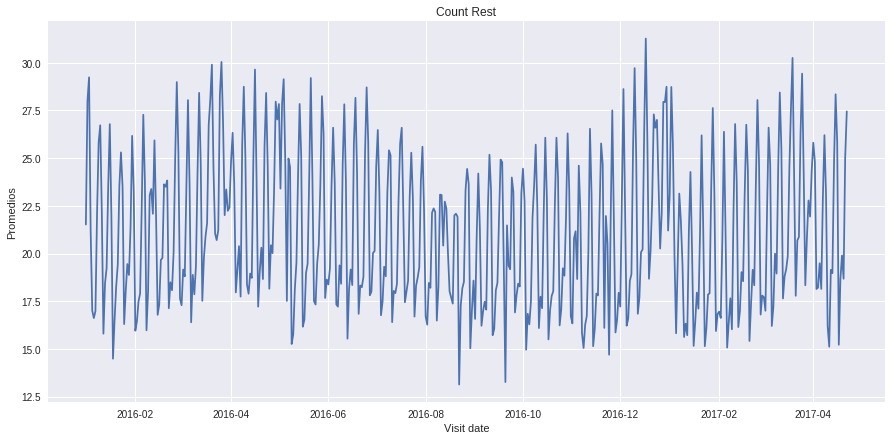

In [0]:
#Promedio de visitantes por restaurant, relativamente constante. No explica el cambio de tendencia.
air_visit_mean=air_visit.groupby(air_visit.visit_date,squeeze=True,sort=True)['visitors'].mean()
air_visit_mean=pd.DataFrame(data=air_visit_mean)
air_visit_mean['visit_date']=air_visit_mean.index
plot_serie(air_visit_mean, 'visit_date', 'visitors',
           'Visit date', 'Promedios', 'Count Rest',
           fecha_desde, fecha_hasta)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: 'visit_date' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  if sys.path[0] == '':


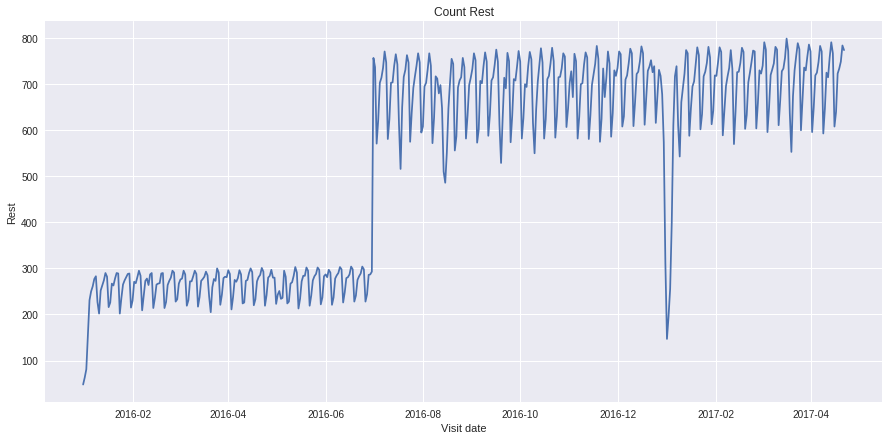

In [0]:
#Grafico de cantidad de restaurants con reservas. Explica el cambio de tendencia.
air_visit_cnt=air_visit.groupby(air_visit.visit_date,squeeze=True,sort=True)['visitors'].count()
air_visit_cnt=pd.DataFrame(data=air_visit_cnt)
air_visit_cnt['visit_date']=air_visit_cnt.index
plot_serie(air_visit_cnt, 'visit_date', 'visitors',
           'Visit date', 'Rest', 'Count Rest',
           fecha_desde, fecha_hasta)

#3.Preparación de los datos

## 3.a) Maestro de Tiempo

In [0]:
def features_fechas(df, date_series,prefijo):
  df[str(prefijo)+'year'] = date_series.dt.year
  df[str(prefijo)+'month'] = date_series.dt.month.apply(lambda x: calendar.month_abbr[x])
  df[str(prefijo)+'weekday'] = date_series.dt.weekday_name
  return df

In [0]:
#Valido que todas las fechas esten dentro de la tabla de tiempo...
t = PrettyTable(['Archivo', 'Min', 'Max'])
t.add_row( ['date_info', np.min(date_info.calendar_date) , np.max(date_info.calendar_date)] )
t.add_row( ['air_visit', np.min(air_visit.visit_date) , np.max(air_visit.visit_date)] )
t.add_row( ['air_res - reserve', np.min(air_res.reserve_datetime) , np.max(air_res.reserve_datetime)] )
t.add_row( ['air_res - visit', np.min(air_res.visit_datetime) , np.max(air_res.visit_datetime)] )
t.add_row( ['hpg_res - reserve', np.min(hpg_res.reserve_datetime) , np.max(hpg_res.reserve_datetime)] )
t.add_row( ['hpg_res - visit', np.min(hpg_res.visit_datetime) , np.max(hpg_res.visit_datetime)] )

print (t)

+-------------------+---------------------+---------------------+
|      Archivo      |         Min         |         Max         |
+-------------------+---------------------+---------------------+
|     date_info     | 2016-01-01 00:00:00 | 2017-05-31 00:00:00 |
|     air_visit     | 2016-01-01 00:00:00 | 2017-04-22 00:00:00 |
| air_res - reserve | 2016-01-01 01:00:00 | 2017-04-22 23:00:00 |
|  air_res - visit  | 2016-01-01 19:00:00 | 2017-05-31 21:00:00 |
| hpg_res - reserve | 2016-01-01 02:00:00 | 2017-04-22 23:00:00 |
|  hpg_res - visit  | 2016-01-01 19:00:00 | 2017-05-31 19:00:00 |
+-------------------+---------------------+---------------------+


In [0]:
#Agrego features adicionales al maestro de tiempo...
date_info = features_fechas( date_info, date_info['calendar_date'],'calendar_' )

if date_info.columns.contains('day_of_week'):
  date_info = date_info.drop(columns='day_of_week')

explorar(date_info)

Tamaño:  (517, 5)
+------------------+----------------+-------+--------+
|     Atributo     |  Tipo de Dato  | Nulos | Unique |
+------------------+----------------+-------+--------+
|  calendar_date   | datetime64[ns] |   0   |  517   |
|   holiday_flg    |     int64      |   0   |   1    |
|  calendar_year   |     int64      |   0   |   2    |
|  calendar_month  |     object     |   0   |   12   |
| calendar_weekday |     object     |   0   |   7    |
+------------------+----------------+-------+--------+



,calendar_date,holiday_flg,calendar_year,calendar_month,calendar_weekday
0,2016-01-01,1,2016,Jan,Friday
1,2016-01-02,1,2016,Jan,Saturday
2,2016-01-03,1,2016,Jan,Sunday
3,2016-01-04,0,2016,Jan,Monday
4,2016-01-05,0,2016,Jan,Tuesday


## 3.b) Anticipación de reservas (delta)

In [0]:
def tiempo_calculos(df):
    df['reserve_datetime_diff'] = df.apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    df['delta_1days'] = df['reserve_datetime_diff'].apply(lambda days: int(days < 1))
    df['delta_2days'] = df['reserve_datetime_diff'].apply(lambda days: int(1 <= days < 2))
    df['delta_7days'] = df['reserve_datetime_diff'].apply(lambda days: int(2 <= days < 7))
    df['delta_long']  = df['reserve_datetime_diff'].apply(lambda days: int(days >= 7))
    
    tmp1 = df.groupby(['air_store_id','visit_date'],
                      as_index=False)[['reserve_datetime_diff',
                                       'reserve_visitors',
                                       'delta_1days',
                                       'delta_2days',
                                       'delta_7days',
                                       'delta_long']].sum().rename(columns={'reserve_datetime_diff': 'rDifSum',
                                                                            'reserve_visitors':'reserve_visitors',
                                                                            'delta_1days': 'delta_1daysSum',
                                                                            'delta_2days': 'delta_2daysSum',
                                                                            'delta_7days': 'delta_7daysSum',
                                                                            'delta_long': 'delta_longSum',
                                                                           })
    tmp2 = df.groupby(['air_store_id','visit_date'],
                      as_index=False)[['reserve_datetime_diff',
                                       'reserve_visitors',
                                       'delta_1days',
                                       'delta_2days',
                                       'delta_7days',
                                       'delta_long']].mean().rename(columns={'reserve_datetime_diff': 'rDifMean',
                                                                             'reserve_visitors':'reserve_visitors_Mean',
                                                                             'delta_1days': 'delta_1daysMean',
                                                                             'delta_2days': 'delta_2daysMean',
                                                                             'delta_7days': 'delta_7daysMean',
                                                                             'delta_long': 'delta_longMean',
                                                                            })
    df = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])
    
    df.visit_date = df.visit_date.dt.date.astype('datetime64')
    return df

In [0]:
def plot_res_delay(df,title,y_lim,
                   date='visit_date',                  
                   date_1=datetime.strptime( '2017 02 01', '%Y %m %d'),
                   date_2=datetime.strptime( '2017 05 31', '%Y %m %d')):

  color = ['y', 'r', 'b', 'g']
  label = ['delay < 1d', '1d < delay < 2d','2d < delay < 7d', 'delay > 7d']
  
  fig = plt.figure(figsize=(15, 7))
  fig.suptitle(title,fontsize = 14)
  ax1 = fig.add_subplot(111)

  for j, col in enumerate(['delta_1daysSum','delta_2daysSum', 'delta_7daysSum', 'delta_longSum']):
      serie=col
      ax1.plot(date,
               serie, 
               data = df[(df[date] >= fecha_desde) & (df[date] <= fecha_hasta) & (df[serie]>0)].
               groupby(date, as_index=False).agg({serie: np.sum}).sort_values( by = date),
               linestyle='-', label = label[j], color = color[j])
      
  ax1.vlines( np.max( air_visit[(air_visit.visit_date >= fecha_desde) & (air_visit.visit_date <= fecha_hasta)]['visit_date']) ,
               0 , 5000 ,
               linestyles = 'dashed',
               label='D day')
  ax1.legend(loc=5)

  ax1.set_ylabel('Visitors [#]', fontsize = 14)
  ax1.set_xlabel('Date', fontsize = 14)
  
  #________
  # limits
  ax1.set_xlim(date_1, date_2)
  ax1.set_ylim(y_lim)
  plt.show()

In [0]:
#Agrego features en AIR_RES y borro para poder agrupar
air_res = tiempo_calculos(air_res)
explorar (air_res)

Tamaño:  (29830, 14)
+-----------------------+----------------+-------+--------+
|        Atributo       |  Tipo de Dato  | Nulos | Unique |
+-----------------------+----------------+-------+--------+
|      air_store_id     |     object     |   0   |  314   |
|       visit_date      | datetime64[ns] |   0   |  433   |
|        rDifSum        |     int64      |   0   |  251   |
|    reserve_visitors   |     int64      |   0   |  125   |
|     delta_1daysSum    |     int64      |   0   |   17   |
|     delta_2daysSum    |     int64      |   0   |   9    |
|     delta_7daysSum    |     int64      |   0   |   13   |
|     delta_longSum     |     int64      |   0   |   31   |
|        rDifMean       |    float64     |   0   |  986   |
| reserve_visitors_Mean |    float64     |   0   |  562   |
|    delta_1daysMean    |    float64     |   0   |   96   |
|    delta_2daysMean    |    float64     |   0   |   71   |
|    delta_7daysMean    |    float64     |   0   |   92   |
|     delta_longMea

/usr/local/lib/python3.6/dist-packages/pandas/core/internals.py:3462: FutureWarning: Passing in 'datetime64' dtype with no frequency is deprecated and will raise in a future version. Please pass in 'datetime64[ns]' instead.
  return self.apply('astype', dtype=dtype, **kwargs)


,air_store_id,visit_date,rDifSum,reserve_visitors,delta_1daysSum,delta_2daysSum,delta_7daysSum,delta_longSum,rDifMean,reserve_visitors_Mean,delta_1daysMean,delta_2daysMean,delta_7daysMean,delta_longMean
0,air_00a91d42b08b08d9,2016-10-31,0,2,1,0,0,0,0.000,2.000,1.000,0.000,0.000,0.000
1,air_00a91d42b08b08d9,2016-12-05,4,9,0,0,1,0,4.000,9.000,0.000,0.000,1.000,0.000
2,air_00a91d42b08b08d9,2016-12-14,6,18,0,0,1,0,6.000,18.000,0.000,0.000,1.000,0.000
3,air_00a91d42b08b08d9,2016-12-17,6,2,0,0,1,0,6.000,2.000,0.000,0.000,1.000,0.000
4,air_00a91d42b08b08d9,2016-12-20,2,4,0,0,1,0,2.000,4.000,0.000,0.000,1.000,0.000


In [0]:
air_visit.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


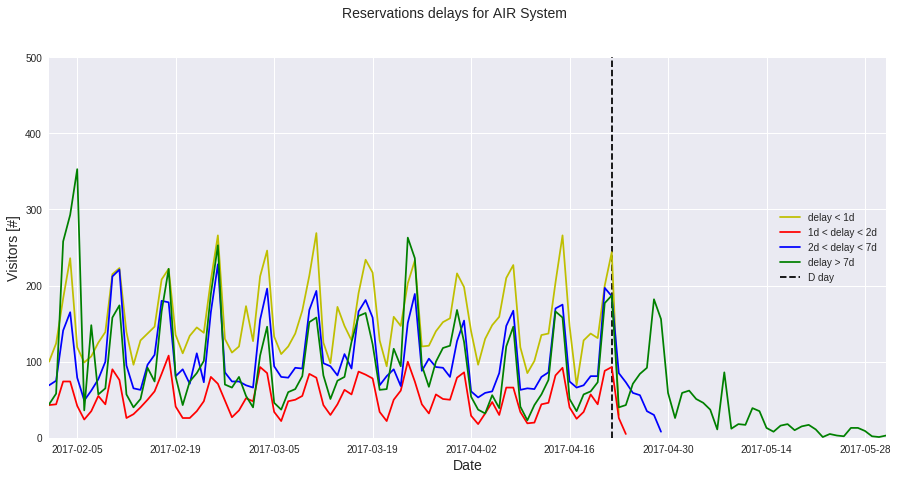

In [0]:
plot_res_delay(df=air_res,title='Reservations delays for AIR System',y_lim=[0,500])

In [0]:
#Agrego features en HPG_RES y borro para poder agrupar
hpg_res=tiempo_calculos(hpg_res)
explorar(hpg_res)

Tamaño:  (18620, 14)
+-----------------------+----------------+-------+--------+
|        Atributo       |  Tipo de Dato  | Nulos | Unique |
+-----------------------+----------------+-------+--------+
|      air_store_id     |     object     |   0   |  150   |
|       visit_date      | datetime64[ns] |   0   |  508   |
|        rDifSum        |     int64      |   0   |  129   |
|    reserve_visitors   |     int64      |   0   |   79   |
|     delta_1daysSum    |     int64      |   0   |   5    |
|     delta_2daysSum    |     int64      |   0   |   4    |
|     delta_7daysSum    |     int64      |   0   |   8    |
|     delta_longSum     |     int64      |   0   |   16   |
|        rDifMean       |    float64     |   0   |  343   |
| reserve_visitors_Mean |    float64     |   0   |  215   |
|    delta_1daysMean    |    float64     |   0   |   19   |
|    delta_2daysMean    |    float64     |   0   |   22   |
|    delta_7daysMean    |    float64     |   0   |   34   |
|     delta_longMea

/usr/local/lib/python3.6/dist-packages/pandas/core/internals.py:3462: FutureWarning: Passing in 'datetime64' dtype with no frequency is deprecated and will raise in a future version. Please pass in 'datetime64[ns]' instead.
  return self.apply('astype', dtype=dtype, **kwargs)


,air_store_id,visit_date,rDifSum,reserve_visitors,delta_1daysSum,delta_2daysSum,delta_7daysSum,delta_longSum,rDifMean,reserve_visitors_Mean,delta_1daysMean,delta_2daysMean,delta_7daysMean,delta_longMean
0,air_00a91d42b08b08d9,2016-01-14,3,2,0,0,1,0,3.000,2.000,0.000,0.000,1.000,0.000
1,air_00a91d42b08b08d9,2016-01-15,5,4,0,0,1,0,5.000,4.000,0.000,0.000,1.000,0.000
2,air_00a91d42b08b08d9,2016-01-16,2,2,0,0,1,0,2.000,2.000,0.000,0.000,1.000,0.000
3,air_00a91d42b08b08d9,2016-01-22,3,2,0,0,1,0,3.000,2.000,0.000,0.000,1.000,0.000
4,air_00a91d42b08b08d9,2016-01-29,6,5,0,0,1,0,6.000,5.000,0.000,0.000,1.000,0.000


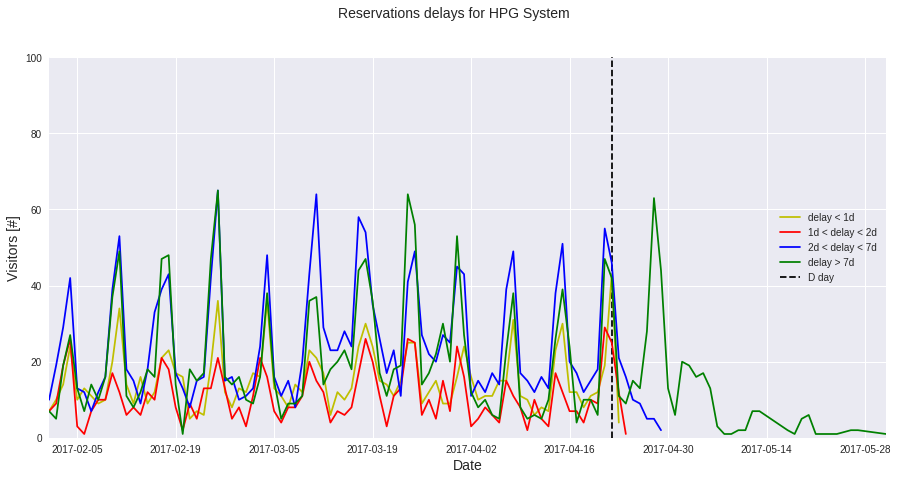

In [0]:
plot_res_delay(df=hpg_res,title='Reservations delays for HPG System',y_lim=[0,100])

In [0]:
#Uno las reservas de uno y otro sistema
df = pd.merge(air_res, hpg_res, how='outer', on=['air_store_id', 'visit_date'] , suffixes = ('_air', '_hpg') )

#Uno las reservas totales con las visitas reales 
df = pd.merge(df , air_visit , how='outer', on=['air_store_id', 'visit_date'] ).sort_values(by = 'visit_date')

#Uno con la información del restaurante
df = pd.merge(df, air_st, how='left', on='air_store_id')

#Uno con la información de las fechas
df = pd.merge(df, date_info, how='left', left_on = 'visit_date', right_on = 'calendar_date' )

#Union de info del clima
df = pd.merge(df, weather, how = 'left' , left_on = ['air_area_name' , 'visit_date'] , right_on = ['air_area_name', 'calendar_date']) 

#Exploración final
explorar(df)

Tamaño:  (258603, 54)
+---------------------------+----------------+--------+--------+
|          Atributo         |  Tipo de Dato  | Nulos  | Unique |
+---------------------------+----------------+--------+--------+
|        air_store_id       |     object     |   0    |  829   |
|         visit_date        | datetime64[ns] |   0    |  517   |
|        rDifSum_air        |    float64     | 228773 |  252   |
|    reserve_visitors_air   |    float64     | 228773 |  126   |
|     delta_1daysSum_air    |    float64     | 228773 |   18   |
|     delta_2daysSum_air    |    float64     | 228773 |   10   |
|     delta_7daysSum_air    |    float64     | 228773 |   14   |
|     delta_longSum_air     |    float64     | 228773 |   32   |
|        rDifMean_air       |    float64     | 228773 |  987   |
| reserve_visitors_Mean_air |    float64     | 228773 |  563   |
|    delta_1daysMean_air    |    float64     | 228773 |   97   |
|    delta_2daysMean_air    |    float64     | 228773 |   72   |
|  

,air_store_id,visit_date,rDifSum_air,reserve_visitors_air,delta_1daysSum_air,delta_2daysSum_air,delta_7daysSum_air,delta_longSum_air,rDifMean_air,reserve_visitors_Mean_air,delta_1daysMean_air,delta_2daysMean_air,delta_7daysMean_air,delta_longMean_air,rDifSum_hpg,reserve_visitors_hpg,delta_1daysSum_hpg,delta_2daysSum_hpg,delta_7daysSum_hpg,delta_longSum_hpg,rDifMean_hpg,reserve_visitors_Mean_hpg,delta_1daysMean_hpg,delta_2daysMean_hpg,delta_7daysMean_hpg,...,latitude,longitude,air_store_by_area_count,state_name,city_name,calendar_date_x,holiday_flg,calendar_year,calendar_month,calendar_weekday,calendar_date_y,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature
0,air_57ed725a1930a5b9,2016-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,35.694,139.704,39,Tōkyō-to,Tōkyō-to Shinjuku-ku,2016-01-01,1,2016,Jan,Friday,2016-01-01,0.000,7.500,0.000,0.000,9.000,2.600,4.500,45.000,1025.400,1022.400,11.800,2.500,12.100,3.600
1,air_e483f5b3c4f310e0,2016-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,33.582,130.348,6,Fukuoka-ken,Fukuoka-ken Fukuoka-shi,2016-01-01,1,2016,Jan,Friday,2016-01-01,0.000,7.300,0.000,0.000,6.600,2.100,7.600,76.000,1031.100,1029.200,10.350,4.300,12.600,3.100
2,air_5c65468938c07fa5,2016-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,35.662,139.704,58,Tōkyō-to,Tōkyō-to Shibuya-ku,2016-01-01,1,2016,Jan,Friday,2016-01-01,0.000,7.500,0.000,0.000,9.000,2.600,4.500,45.000,1025.400,1022.400,11.800,2.500,12.100,3.600
3,air_35c4732dcbfe31be,2016-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,34.695,135.198,17,Hyōgo-ken,Hyōgo-ken Kōbe-shi,2016-01-01,1,2016,Jan,Friday,2016-01-01,0.000,7.900,0.000,0.000,8.600,2.800,6.200,59.000,1029.600,1025.800,0.000,1.800,12.300,4.800
4,air_d97dabf7aae60da5,2016-01-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,35.669,139.707,2,Tōkyō-to,Tōkyō-to Shibuya-ku,2016-01-01,1,2016,Jan,Friday,2016-01-01,0.000,7.500,0.000,0.000,9.000,2.600,4.500,45.000,1025.400,1022.400,11.800,2.500,12.100,3.600


In [0]:
#Reordeno columnas
df['reserve_visitors'] = df.reserve_visitors_air.fillna(0) + df.reserve_visitors_hpg.fillna(0)

df = df[['air_store_id' ,'visit_date' ,'visitors' ,'reserve_visitors','air_genre_name' ,'air_area_name' ,'latitude' ,'longitude',
         'state_name','city_name','holiday_flg','calendar_year','calendar_month' ,'calendar_weekday','rDifSum_air',
         'reserve_visitors_air','delta_1daysSum_air','delta_2daysSum_air','delta_7daysSum_air','delta_longSum_air',
         'rDifMean_air','reserve_visitors_Mean_air','delta_1daysMean_air','delta_2daysMean_air','delta_7daysMean_air',
         'delta_longMean_air','rDifSum_hpg','reserve_visitors_hpg','delta_1daysSum_hpg','delta_2daysSum_hpg',
         'delta_7daysSum_hpg','delta_longSum_hpg','rDifMean_hpg','reserve_visitors_Mean_hpg','delta_1daysMean_hpg',
         'delta_2daysMean_hpg','delta_7daysMean_hpg','delta_longMean_hpg','air_store_by_area_count','precipitation',
         'avg_temperature','total_snowfall','deepest_snowfall','hours_sunlight','avg_wind_speed','avg_vapor_pressure',
         'avg_humidity','avg_sea_pressure','avg_local_pressure','solar_radiation','cloud_cover','high_temperature','low_temperature']]

df.head()

,air_store_id,visit_date,visitors,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,state_name,city_name,holiday_flg,calendar_year,calendar_month,calendar_weekday,rDifSum_air,reserve_visitors_air,delta_1daysSum_air,delta_2daysSum_air,delta_7daysSum_air,delta_longSum_air,rDifMean_air,reserve_visitors_Mean_air,delta_1daysMean_air,delta_2daysMean_air,delta_7daysMean_air,...,delta_1daysSum_hpg,delta_2daysSum_hpg,delta_7daysSum_hpg,delta_longSum_hpg,rDifMean_hpg,reserve_visitors_Mean_hpg,delta_1daysMean_hpg,delta_2daysMean_hpg,delta_7daysMean_hpg,delta_longMean_hpg,air_store_by_area_count,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature
0,air_57ed725a1930a5b9,2016-01-01,33.000,0.000,Cafe/Sweets,Tōkyō-to Shinjuku-ku Kabukichō,35.694,139.704,Tōkyō-to,Tōkyō-to Shinjuku-ku,1,2016,Jan,Friday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,39,0.000,7.500,0.000,0.000,9.000,2.600,4.500,45.000,1025.400,1022.400,11.800,2.500,12.100,3.600
1,air_e483f5b3c4f310e0,2016-01-01,1.000,0.000,Cafe/Sweets,Fukuoka-ken Fukuoka-shi Momochi,33.582,130.348,Fukuoka-ken,Fukuoka-ken Fukuoka-shi,1,2016,Jan,Friday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,6,0.000,7.300,0.000,0.000,6.600,2.100,7.600,76.000,1031.100,1029.200,10.350,4.300,12.600,3.100
2,air_5c65468938c07fa5,2016-01-01,8.000,0.000,Other,Tōkyō-to Shibuya-ku Shibuya,35.662,139.704,Tōkyō-to,Tōkyō-to Shibuya-ku,1,2016,Jan,Friday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,58,0.000,7.500,0.000,0.000,9.000,2.600,4.500,45.000,1025.400,1022.400,11.800,2.500,12.100,3.600
3,air_35c4732dcbfe31be,2016-01-01,16.000,0.000,Dining bar,Hyōgo-ken Kōbe-shi Kumoidōri,34.695,135.198,Hyōgo-ken,Hyōgo-ken Kōbe-shi,1,2016,Jan,Friday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,17,0.000,7.900,0.000,0.000,8.600,2.800,6.200,59.000,1029.600,1025.800,0.000,1.800,12.300,4.800
4,air_d97dabf7aae60da5,2016-01-01,102.000,0.000,Cafe/Sweets,Tōkyō-to Shibuya-ku Jingūmae,35.669,139.707,Tōkyō-to,Tōkyō-to Shibuya-ku,1,2016,Jan,Friday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2,0.000,7.500,0.000,0.000,9.000,2.600,4.500,45.000,1025.400,1022.400,11.800,2.500,12.100,3.600


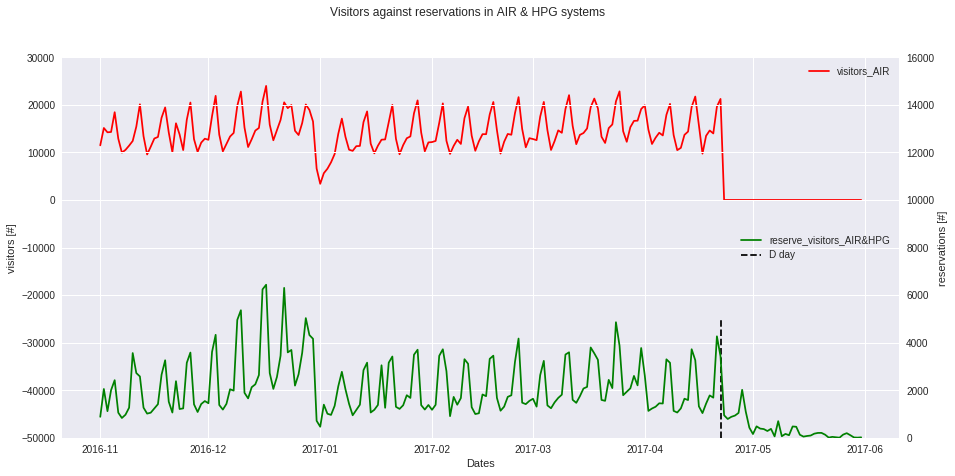

In [0]:
fecha_desde = datetime.strptime( '2016 11 01', '%Y %m %d')
fecha_hasta = datetime.strptime( '2017 05 31', '%Y %m %d')

series_comparisson(
    df, 'visit_date', 'visitors', 'AIR',
    df, 'visit_date', 'reserve_visitors', 'AIR&HPG',
    df, 'visit_date', 'reserve_visitors', 'HPG',
    fecha_desde, fecha_hasta,
    rango_y1=[-50000,30000],rango_y2=[0,16000],
    graph1 = 1 , graph2 = 1, graph3 = 0,
    title = "Visitors against reservations in AIR & HPG systems"
)

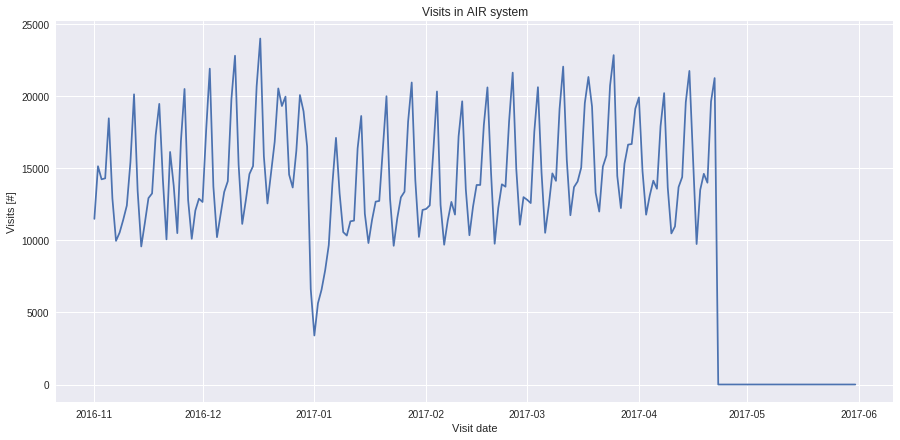

In [0]:
plot_serie(df, 'visit_date', 'visitors',
           'Visit date', 'Visits [#]', 'Visits in AIR system',
           fecha_desde, fecha_hasta)

## 3.c) Overbooking

In [0]:
df['reserve_visitors_air/visitors']=df['reserve_visitors_air']/df['visitors']
df['reserve_visitors_hpg/visitors']=df['reserve_visitors_hpg']/df['visitors']

filtro = (~df['reserve_visitors_hpg/visitors'].isna()) & (~df['reserve_visitors_air/visitors'].isna())
df_visitors=df.loc[filtro,:]

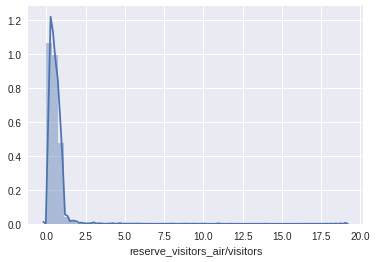

In [0]:
# Import library and dataset
import seaborn as sns
# df = sns.load_dataset('iris')
 
# Make default histogram of sepal length
sns.distplot( df_visitors['reserve_visitors_air/visitors'],
#              bins=50
            )
sns.plt.show()

In [0]:
df_visitors['reserve_visitors_air/visitors'].describe()

count   5916.000
mean       0.563
std        0.675
min        0.013
25%        0.261
50%        0.471
75%        0.732
max       19.000
Name: reserve_visitors_air/visitors, dtype: float64

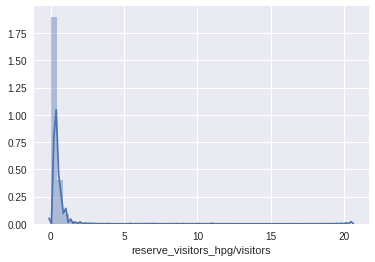

In [0]:
# Import library and dataset
import seaborn as sns
# df = sns.load_dataset('iris')
 
# Make default histogram of sepal length
sns.distplot( df_visitors['reserve_visitors_hpg/visitors'],bins=50 )
sns.plt.show()

In [0]:
df_visitors['reserve_visitors_hpg/visitors'].describe()

count   5916.000
mean       0.332
std        0.597
min        0.010
25%        0.118
50%        0.211
75%        0.389
max       20.500
Name: reserve_visitors_hpg/visitors, dtype: float64

## 3.d) Días sin reservas

Se detectan valores faltantes de reservas entre el 27-jul. y 25-oct. para lo cual se generará una flag de valores faltantes para ayudar al modelo. Se deja el código comentado para validación.

In [0]:
"""
fecha_desde = datetime.strptime( '2016 07 27', '%Y %m %d')
fecha_hasta = datetime.strptime( '2016 10 25', '%Y %m %d')

no_reservations = df[
    (df['visit_date'] >= fecha_desde) & (df['visit_date'] <= fecha_hasta)].pivot_table( 
    values = ['visitors', 'reserve_visitors','reserve_visitors_air','reserve_visitors_hpg'], 
    index = 'visit_date' , 
    aggfunc = np.sum )

no_reservations = pd.merge(no_reservations , 
                           date_info[(date_info['calendar_date'] >= fecha_desde) & (date_info['calendar_date'] <= fecha_hasta)] , 
                           left_index = True , 
                           right_on = 'calendar_date' , 
                           how = 'outer')

no_reservations.set_index('calendar_date', inplace = True)
"""

"\nfecha_desde = datetime.strptime( '2016 07 27', '%Y %m %d')\nfecha_hasta = datetime.strptime( '2016 10 25', '%Y %m %d')\n\nno_reservations = df[\n    (df['visit_date'] >= fecha_desde) & (df['visit_date'] <= fecha_hasta)].pivot_table( \n    values = ['visitors', 'reserve_visitors','reserve_visitors_air','reserve_visitors_hpg'], \n    index = 'visit_date' , \n    aggfunc = np.sum )\n\nno_reservations = pd.merge(no_reservations , \n                           date_info[(date_info['calendar_date'] >= fecha_desde) & (date_info['calendar_date'] <= fecha_hasta)] , \n                           left_index = True , \n                           right_on = 'calendar_date' , \n                           how = 'outer')\n\nno_reservations.set_index('calendar_date', inplace = True)\n"

In [0]:
fecha_desde = datetime.strptime( '2016 07 27', '%Y %m %d')
fecha_hasta = datetime.strptime( '2016 10 25', '%Y %m %d')

df['missing_air_res'] = df.visit_date.apply(lambda x: 1 if (x >= fecha_desde) & (x <= fecha_hasta) else 0 )

## 3.e) Totales de reservas (AIR & HPG)

Se agregan features que pueden ser relevantes para el resultado final, pero de por si, no agregar valor.

In [0]:
hpg_res_raw.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_date,reserve_date
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,2016-01-01,2016-01-01
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2016-01-01,2016-01-01
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2,2016-01-01,2016-01-01
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5,2016-01-01,2016-01-01
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13,2016-01-01,2016-01-01


In [0]:
air_res.head()

,air_store_id,visit_date,rDifSum,reserve_visitors,delta_1daysSum,delta_2daysSum,delta_7daysSum,delta_longSum,rDifMean,reserve_visitors_Mean,delta_1daysMean,delta_2daysMean,delta_7daysMean,delta_longMean
0,air_00a91d42b08b08d9,2016-10-31,0,2,1,0,0,0,0.000,2.000,1.000,0.000,0.000,0.000
1,air_00a91d42b08b08d9,2016-12-05,4,9,0,0,1,0,4.000,9.000,0.000,0.000,1.000,0.000
2,air_00a91d42b08b08d9,2016-12-14,6,18,0,0,1,0,6.000,18.000,0.000,0.000,1.000,0.000
3,air_00a91d42b08b08d9,2016-12-17,6,2,0,0,1,0,6.000,2.000,0.000,0.000,1.000,0.000
4,air_00a91d42b08b08d9,2016-12-20,2,4,0,0,1,0,2.000,4.000,0.000,0.000,1.000,0.000


In [0]:
df.head()

,air_store_id,visit_date,visitors,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,state_name,city_name,holiday_flg,calendar_year,calendar_month,calendar_weekday,rDifSum_air,reserve_visitors_air,delta_1daysSum_air,delta_2daysSum_air,delta_7daysSum_air,delta_longSum_air,rDifMean_air,reserve_visitors_Mean_air,delta_1daysMean_air,delta_2daysMean_air,delta_7daysMean_air,...,delta_longSum_hpg,rDifMean_hpg,reserve_visitors_Mean_hpg,delta_1daysMean_hpg,delta_2daysMean_hpg,delta_7daysMean_hpg,delta_longMean_hpg,air_store_by_area_count,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature,reserve_visitors_air/visitors,reserve_visitors_hpg/visitors,missing_air_res
0,air_57ed725a1930a5b9,2016-01-01,33.000,0.000,Cafe/Sweets,Tōkyō-to Shinjuku-ku Kabukichō,35.694,139.704,Tōkyō-to,Tōkyō-to Shinjuku-ku,1,2016,Jan,Friday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,39,0.000,7.500,0.000,0.000,9.000,2.600,4.500,45.000,1025.400,1022.400,11.800,2.500,12.100,3.600,nan,nan,0
1,air_e483f5b3c4f310e0,2016-01-01,1.000,0.000,Cafe/Sweets,Fukuoka-ken Fukuoka-shi Momochi,33.582,130.348,Fukuoka-ken,Fukuoka-ken Fukuoka-shi,1,2016,Jan,Friday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,6,0.000,7.300,0.000,0.000,6.600,2.100,7.600,76.000,1031.100,1029.200,10.350,4.300,12.600,3.100,nan,nan,0
2,air_5c65468938c07fa5,2016-01-01,8.000,0.000,Other,Tōkyō-to Shibuya-ku Shibuya,35.662,139.704,Tōkyō-to,Tōkyō-to Shibuya-ku,1,2016,Jan,Friday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,58,0.000,7.500,0.000,0.000,9.000,2.600,4.500,45.000,1025.400,1022.400,11.800,2.500,12.100,3.600,nan,nan,0
3,air_35c4732dcbfe31be,2016-01-01,16.000,0.000,Dining bar,Hyōgo-ken Kōbe-shi Kumoidōri,34.695,135.198,Hyōgo-ken,Hyōgo-ken Kōbe-shi,1,2016,Jan,Friday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,17,0.000,7.900,0.000,0.000,8.600,2.800,6.200,59.000,1029.600,1025.800,0.000,1.800,12.300,4.800,nan,nan,0
4,air_d97dabf7aae60da5,2016-01-01,102.000,0.000,Cafe/Sweets,Tōkyō-to Shibuya-ku Jingūmae,35.669,139.707,Tōkyō-to,Tōkyō-to Shibuya-ku,1,2016,Jan,Friday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,2,0.000,7.500,0.000,0.000,9.000,2.600,4.500,45.000,1025.400,1022.400,11.800,2.500,12.100,3.600,nan,nan,0


In [0]:
hpg_aux = hpg_res_raw.groupby('visit_date')['reserve_visitors'].sum()
air_aux = air_res.groupby('visit_date')['reserve_visitors'].sum()

def sum_visitors(df,date):
  try:
    ans = df[date]
    return ans
  except:
    return np.nan

In [0]:
#### df['hpg_res_sum']=df['hpg_res_sum']=df['visit_date'].apply(lambda x: sum_visitors(hpg_res_raw,x))

df['hpg_res_sum'] = df.apply(lambda x: sum_visitors(hpg_aux,x['visit_date']), axis=1)
df['air_res_sum'] = df.apply(lambda x: sum_visitors(air_aux,x['visit_date']), axis=1)

del [air_aux,hpg_aux]

In [0]:
df.tail()

,air_store_id,visit_date,visitors,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,state_name,city_name,holiday_flg,calendar_year,calendar_month,calendar_weekday,rDifSum_air,reserve_visitors_air,delta_1daysSum_air,delta_2daysSum_air,delta_7daysSum_air,delta_longSum_air,rDifMean_air,reserve_visitors_Mean_air,delta_1daysMean_air,delta_2daysMean_air,delta_7daysMean_air,...,reserve_visitors_Mean_hpg,delta_1daysMean_hpg,delta_2daysMean_hpg,delta_7daysMean_hpg,delta_longMean_hpg,air_store_by_area_count,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature,reserve_visitors_air/visitors,reserve_visitors_hpg/visitors,missing_air_res,hpg_res_sum,air_res_sum
258598,air_1033310359ceeac1,2017-05-30,nan,8.000,Izakaya,Tōkyō-to Kōtō-ku Tomioka,35.671,139.797,Tōkyō-to,Tōkyō-to Kōtō-ku,0,2017,May,Tuesday,41.000,8.000,0.000,0.000,0.000,1.000,41.000,8.000,0.000,0.000,0.000,...,nan,nan,nan,nan,nan,2,0.000,23.300,0.000,0.000,12.100,3.000,19.800,70.000,1009.700,1006.900,27.110,5.300,29.100,17.200,nan,nan,0,166,8.000
258599,air_900d755ebd2f7bbd,2017-05-31,nan,10.000,Italian/French,Tōkyō-to Chūō-ku Ginza,35.672,139.771,Tōkyō-to,Tōkyō-to Chūō-ku,0,2017,May,Wednesday,42.000,10.000,0.000,0.000,0.000,1.000,42.000,10.000,0.000,0.000,0.000,...,nan,nan,nan,nan,nan,14,0.000,23.600,0.000,0.000,4.700,3.700,22.100,76.000,1006.400,1003.600,18.720,10.000,27.500,20.700,nan,nan,0,479,16.000
258600,air_877f79706adbfb06,2017-05-31,nan,3.000,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658,139.752,Tōkyō-to,Tōkyō-to Minato-ku,0,2017,May,Wednesday,48.000,3.000,0.000,0.000,0.000,1.000,48.000,3.000,0.000,0.000,0.000,...,nan,nan,nan,nan,nan,51,0.000,23.600,0.000,0.000,4.700,3.700,22.100,76.000,1006.400,1003.600,18.720,10.000,27.500,20.700,nan,nan,0,479,16.000
258601,air_3cad29d1a23209d2,2017-05-31,nan,3.000,Japanese food,Tōkyō-to Shibuya-ku Shibuya,35.662,139.704,Tōkyō-to,Tōkyō-to Shibuya-ku,0,2017,May,Wednesday,39.000,3.000,0.000,0.000,0.000,1.000,39.000,3.000,0.000,0.000,0.000,...,nan,nan,nan,nan,nan,58,0.000,23.600,0.000,0.000,4.700,3.700,22.100,76.000,1006.400,1003.600,18.720,10.000,27.500,20.700,nan,nan,0,479,16.000
258602,air_290e7a57b390f78e,2017-05-31,nan,3.000,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658,139.752,Tōkyō-to,Tōkyō-to Minato-ku,0,2017,May,Wednesday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,3.000,0.000,0.000,0.000,1.000,51,0.000,23.600,0.000,0.000,4.700,3.700,22.100,76.000,1006.400,1003.600,18.720,10.000,27.500,20.700,nan,nan,0,479,16.000


## 3.f) Ciudades

In [0]:
ciudades = df.pivot_table(values=['longitude','latitude'] , index = 'state_name', aggfunc = 'mean' )
ciudades['state_name'] = ciudades.index
ciudades.reset_index(drop = True, inplace = True)
ciudades

,latitude,longitude,state_name
0,33.587,130.426,Fukuoka-ken
1,34.407,132.640,Hiroshima-ken
2,43.320,141.892,Hokkaidō
3,34.740,135.111,Hyōgo-ken
4,38.269,140.870,Miyagi-ken
5,37.762,138.932,Niigata-ken
6,34.802,137.973,Shizuoka-ken
7,35.677,139.712,Tōkyō-to
8,34.690,135.512,Ōsaka-fu


In [0]:
ciudades['longitude']

0   130.426
1   132.640
2   141.892
3   135.111
4   140.870
5   138.932
6   137.973
7   139.712
8   135.512
Name: longitude, dtype: float64

In [0]:
"""
di_ciudades={0:'Tokyo',
             1:'Osaka',
             2:'Sapporo',
             3:'Fukuoka',
             4:'Niigata',
             5:'Hiroshima',
             6:'Shizouku',
             7:'Sendai',
             8:'North',
             9:'Kobe'}

df['ciudades']= df['cluster_ciudad']
df.replace({'ciudades': di_ciudades},inplace=True)
df[['cluster_ciudad','ciudades']].head()
"""

"\ndi_ciudades={0:'Tokyo',\n             1:'Osaka',\n             2:'Sapporo',\n             3:'Fukuoka',\n             4:'Niigata',\n             5:'Hiroshima',\n             6:'Shizouku',\n             7:'Sendai',\n             8:'North',\n             9:'Kobe'}\n\ndf['ciudades']= df['cluster_ciudad']\ndf.replace({'ciudades': di_ciudades},inplace=True)\ndf[['cluster_ciudad','ciudades']].head()\n"

Mapa de Japón que no agrega mucha información

In [0]:
"""
from mpl_toolkits.basemap import Basemap
# import matplotlib.pyplot as plt
m = Basemap(projection='aeqd',width=2000000,height=2000000, lat_0=37.5, lon_0=138.2)

cx = ciudades['latitude'].tolist()  #[c[0] for c in kmeans.cluster_centers_]
cy = ciudades['longitude'].tolist() #[c[1] for c in kmeans.cluster_centers_]
cm = plt.get_cmap('gist_rainbow')
colors = [cm(2.*i/10) for i in range(10)]
colored = [colors[k] for k in ciudades.index]
f,axa = plt.subplots(1,1,figsize=(15,16))
m.drawcoastlines()
m.fillcontinents(color='lightgray',lake_color='aqua',zorder=1)
m.scatter(df.longitude.values,df.latitude.values,color=colored,s=20,alpha=1,zorder=999,latlon=True)
m.scatter(cx,cy,color='Black',s=50,alpha=1,latlon=True,zorder=9999)
plt.setp(axa.get_yticklabels(), visible=True)

plt.annotate('Fukuoka', xy=(0.04, 0.32), xycoords='axes fraction',fontsize=20)
plt.annotate('Shikoku', xy=(0.25, 0.25), xycoords='axes fraction',fontsize=20)
plt.annotate('Hiroshima', xy=(0.2, 0.36), xycoords='axes fraction',fontsize=20)
plt.annotate('Osaka', xy=(0.40, 0.30), xycoords='axes fraction',fontsize=20)
plt.annotate('Tokyo', xy=(0.60, 0.4), xycoords='axes fraction',fontsize=20)
plt.annotate('Shizuoka', xy=(0.50, 0.32), xycoords='axes fraction',fontsize=20)
plt.annotate('Niigata', xy=(0.48, 0.54), xycoords='axes fraction',fontsize=20)
plt.annotate('Fukushima', xy=(0.62, 0.54), xycoords='axes fraction',fontsize=20)
plt.annotate('Hokkaido', xy=(0.7, 0.74), xycoords='axes fraction',fontsize=20)

for i in range(len(cx)):
    xpt,ypt = m(cx[i],cy[i])
    plt.annotate(i, (xpt+500,ypt+500),zorder=99999,fontsize=16)

plt.show()
"""

"\nfrom mpl_toolkits.basemap import Basemap\n# import matplotlib.pyplot as plt\nm = Basemap(projection='aeqd',width=2000000,height=2000000, lat_0=37.5, lon_0=138.2)\n\ncx = ciudades['latitude'].tolist()  #[c[0] for c in kmeans.cluster_centers_]\ncy = ciudades['longitude'].tolist() #[c[1] for c in kmeans.cluster_centers_]\ncm = plt.get_cmap('gist_rainbow')\ncolors = [cm(2.*i/10) for i in range(10)]\ncolored = [colors[k] for k in ciudades.index]\nf,axa = plt.subplots(1,1,figsize=(15,16))\nm.drawcoastlines()\nm.fillcontinents(color='lightgray',lake_color='aqua',zorder=1)\nm.scatter(df.longitude.values,df.latitude.values,color=colored,s=20,alpha=1,zorder=999,latlon=True)\nm.scatter(cx,cy,color='Black',s=50,alpha=1,latlon=True,zorder=9999)\nplt.setp(axa.get_yticklabels(), visible=True)\n\nplt.annotate('Fukuoka', xy=(0.04, 0.32), xycoords='axes fraction',fontsize=20)\nplt.annotate('Shikoku', xy=(0.25, 0.25), xycoords='axes fraction',fontsize=20)\nplt.annotate('Hiroshima', xy=(0.2, 0.36), xyc

# 4.Preparación de DF

In [0]:
import pickle
from google.colab import files

In [0]:
def guardar_pickle(df,pkl_name):
  nombre= pkl_name
  df.to_pickle(nombre, compression='gzip')
  files.download(nombre)
  
def importar_pickle(pkl_name,file_id):
  df=pd.DataFrame()
  json_import = drive.CreateFile({'id':file_id}) #El ID único del archivo en cuestión
  json_import.GetContentFile(pkl_name)
  df = pd.read_pickle(pkl_name, compression='gzip')
  return df

In [0]:
# guardar_pickle(df,'df_4.pkl')
df=importar_pickle('df_4.pkl','1mnotkRHF3SRXWPN4Tf0x5dak3tqx0EMf')

In [0]:
# explorar(df)

## Filtrado de locales

In [0]:
#Buscamos cuales son los locales con mayor cantidad de vistantes
df.groupby('air_store_id').agg({'visitors':sum})['visitors'].nlargest(10)[:]
# df=df.loc[df['air_store_id'].isin(['air_03963426c9312048']),:]
# df=df.loc[df['air_store_id'].isin(['air_e55abd740f93ecc4']),:]
# df=df.loc[df['air_store_id'].isin(['air_a7404a854919e990']),:]
# df=df.loc[df['air_store_id'].isin(['air_4cca5666eaf5c709']),:]
# df=df.loc[df['air_store_id'].isin(['air_506fe758114df773']),:]
# df=df.loc[df['air_store_id'].isin(['air_c6ffd6a93e6b68d6']),:]
# df=df.loc[df['air_store_id'].isin(['air_a7404a854919e990']),:]
# df=df.loc[df['air_store_id'].isin(['air_399904bdb7685ca0']),:]
# df=df.loc[df['air_store_id'].isin(['air_5c817ef28f236bdf']),:]
df=df.loc[df['air_store_id'].isin(['air_681f96e6a6595f82']),:]

In [0]:
filtrar_air_st = False
n_stores=20

if filtrar_air_st:
  import random
  lst_stores=list(df['air_store_id'].unique())
  random.seed(99)
  stores_filter = random.choices(population=lst_stores, k=n_stores)
  df=df.loc[df['air_store_id'].isin(stores_filter),:]

## Dummies

In [0]:
lst_dummies = ['air_store_id',
               'air_genre_name',
               'air_area_name',
               'state_name',
               'city_name',
               'calendar_year',
               'calendar_month',
               'calendar_weekday',
              ]

# df_dummies = df[lst_dummies]
df_dummies = pd.get_dummies(df[lst_dummies],
                           columns=lst_dummies,
                           prefix=lst_dummies)
df = pd.concat([df,
                df_dummies],
               axis=1)

lst_dummies = list(df_dummies.columns)

## Train/Test

In [0]:
fecha_limite='2017-02-24'
df_train = df.loc[df['visit_date']<=fecha_limite,:]
df_test =  df.loc[df['visit_date']>fecha_limite,:]

In [799]:
df_train.shape

(351, 84)

In [800]:
list(df_train.columns)

['air_store_id',
 'visit_date',
 'visitors',
 'reserve_visitors',
 'air_genre_name',
 'air_area_name',
 'latitude',
 'longitude',
 'state_name',
 'city_name',
 'holiday_flg',
 'calendar_year',
 'calendar_month',
 'calendar_weekday',
 'rDifSum_air',
 'reserve_visitors_air',
 'delta_1daysSum_air',
 'delta_2daysSum_air',
 'delta_7daysSum_air',
 'delta_longSum_air',
 'rDifMean_air',
 'reserve_visitors_Mean_air',
 'delta_1daysMean_air',
 'delta_2daysMean_air',
 'delta_7daysMean_air',
 'delta_longMean_air',
 'rDifSum_hpg',
 'reserve_visitors_hpg',
 'delta_1daysSum_hpg',
 'delta_2daysSum_hpg',
 'delta_7daysSum_hpg',
 'delta_longSum_hpg',
 'rDifMean_hpg',
 'reserve_visitors_Mean_hpg',
 'delta_1daysMean_hpg',
 'delta_2daysMean_hpg',
 'delta_7daysMean_hpg',
 'delta_longMean_hpg',
 'air_store_by_area_count',
 'precipitation',
 'avg_temperature',
 'total_snowfall',
 'deepest_snowfall',
 'hours_sunlight',
 'avg_wind_speed',
 'avg_vapor_pressure',
 'avg_humidity',
 'avg_sea_pressure',
 'avg_local_pr

## TSFresh

## Estandarización

In [0]:
def normalize_ts(x):
  ans = (x - min_ts) / (max_ts - min_ts)
  return ans


df_train['visit_date_unix'] = df_train.visit_date.apply(lambda x: x.timestamp())
df_test['visit_date_unix'] =  df_test.visit_date.apply(lambda x: x.timestamp())

min_ts=df_train['visit_date_unix'].min()
max_ts=df_train['visit_date_unix'].max()


df_train['visit_date_unix'] = df_train['visit_date_unix'].apply(lambda x: normalize_ts(x))
df_test['visit_date_unix'] =  df_test['visit_date_unix'].apply(lambda x: normalize_ts(x))

In [0]:
lst_numericas =  ['latitude',
                  'longitude',
                  'rDifSum_air',
                  'delta_1daysSum_air',
                  'delta_2daysSum_air',
                  'delta_7daysSum_air',
                  'delta_longSum_air',
                  'rDifMean_air',
                  'reserve_visitors',
                  'reserve_visitors_Mean_air',
                  'delta_1daysMean_air',
                  'delta_2daysMean_air',
                  'delta_7daysMean_air',
                  'delta_longMean_air',
                  'rDifSum_hpg', 
                  'reserve_visitors_hpg', 
                  'delta_1daysSum_hpg',
                  'delta_2daysSum_hpg',
                  'delta_7daysSum_hpg', 
                  'delta_longSum_hpg',
                  'rDifMean_hpg', 
                  'reserve_visitors_Mean_hpg',
                  'delta_1daysMean_hpg',
                  'delta_2daysMean_hpg', 
                  'delta_7daysMean_hpg', 
                  'delta_longMean_hpg',
                  'air_store_by_area_count', 
                  'precipitation', 
                  'avg_temperature',
                  'total_snowfall', 
                  'deepest_snowfall', 
                  'hours_sunlight',
                  'avg_wind_speed', 
                  'avg_vapor_pressure', 
                  'avg_humidity',
                  'avg_sea_pressure', 
                  'avg_local_pressure', 
                  'solar_radiation',
                  'cloud_cover', 
                  'high_temperature', 
                  'low_temperature',
                  'hpg_res_sum',
                  'air_res_sum',
#                   'y_hat_prophet',
#                   'tlag_prediccion',
                 ]

# lst_lag = ['lag_01','lag_02', 'lag_03', 'lag_04', 'lag_05', 'lag_06', 'lag_07', 'lag_08','lag_09','lag_10',
#            'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15','lag_16', 'lag_17', 'lag_18', 'lag_19','lag_20',
#            'lag_21', 'lag_22','lag_23', 'lag_24', 'lag_25', 'lag_26', 'lag_27', 'lag_28', 'lag_29','lag_30']

# lst_lag_null = [x+'_null' for x in lst_lag]

list_no_procesar = ['holiday_flg',
                    'visit_date_unix',
                    'missing_air_res',
#                     'id_concat'
                   ]


lst_y = ['visitors',
        ]

In [0]:
#Flag con nulos para lista de yhat_tlag
# for col in lst_lag:
#   df_train[col+'_null'] = df_train[col].isna()
#   df_train[col].fillna(0, inplace = True )
  
#   df_test[col+'_null'] = df_test[col].isna()
#   df_test[col].fillna(0, inplace = True ) 

In [804]:
# df['y_hat_prophet'].fillna(0, inplace = True )

from sklearn.preprocessing import StandardScaler
# X_cont_index   =df_train[lst_numericas+lst_lag].index
# X_cont_columns =df_train[lst_numericas+lst_lag].columns
X_cont_index   =df_train[lst_numericas].index
X_cont_columns =df_train[lst_numericas].columns

scaler = StandardScaler()
# X_continuas = scaler.fit_transform(df_train[lst_numericas+lst_lag])
X_continuas = scaler.fit_transform(df_train[lst_numericas])
X_continuas = pd.DataFrame(X_continuas,
                           index=X_cont_index,
                           columns=X_cont_columns)


X_train_DF = pd.concat([X_continuas,
                     df_train[lst_dummies],
#                      df_train[lst_lag_null],
                     df_train[list_no_procesar]],
                    axis=1)

y_train_DF = df_train['visitors']

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:776: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:781: RuntimeWarning: Degrees of freedom <= 0 for slice.
  new_unnormalized_variance = np.nanvar(X, axis=0) * new_sample_count
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [805]:
# df['y_hat_prophet'].fillna(0, inplace = True )
# X_cont_index   =df_test[lst_numericas+lst_lag].index
# X_cont_columns =df_test[lst_numericas+lst_lag].columns

X_cont_index   =df_test[lst_numericas].index
X_cont_columns =df_test[lst_numericas].columns


# X_continuas = scaler.transform(df_test[lst_numericas+lst_lag])
X_continuas = scaler.transform(df_test[lst_numericas])
X_continuas = pd.DataFrame(X_continuas,
                           index=X_cont_index,
                           columns=X_cont_columns)


X_test_DF = pd.concat([X_continuas,
                    df_test[lst_dummies],
#                     df_test[lst_lag_null],
                    df_test[list_no_procesar]],
                   axis=1)

y_test_DF = df_test['visitors']

df_test_DF = pd.concat([X_test_DF,
                    df_test['visitors']],
                   axis=1)

df_train_DF = pd.concat([X_train_DF,
                    df_train['visitors']],
                   axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


In [806]:
X_train_DF.shape

(351, 72)

In [807]:
len(y_train_DF)

351

In [808]:
df_train.head()

,air_store_id,visit_date,visitors,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,state_name,city_name,holiday_flg,calendar_year,calendar_month,calendar_weekday,rDifSum_air,reserve_visitors_air,delta_1daysSum_air,delta_2daysSum_air,delta_7daysSum_air,delta_longSum_air,rDifMean_air,reserve_visitors_Mean_air,delta_1daysMean_air,delta_2daysMean_air,delta_7daysMean_air,...,air_area_name_Tōkyō-to Minato-ku Shibakōen,state_name_Tōkyō-to,city_name_Tōkyō-to Minato-ku,calendar_year_2016,calendar_year_2017,calendar_month_Apr,calendar_month_Aug,calendar_month_Dec,calendar_month_Feb,calendar_month_Jan,calendar_month_Jul,calendar_month_Jun,calendar_month_Mar,calendar_month_May,calendar_month_Nov,calendar_month_Oct,calendar_month_Sep,calendar_weekday_Friday,calendar_weekday_Monday,calendar_weekday_Saturday,calendar_weekday_Sunday,calendar_weekday_Thursday,calendar_weekday_Tuesday,calendar_weekday_Wednesday,visit_date_unix
561,air_681f96e6a6595f82,2016-01-05,26.000,0.000,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658,139.752,Tōkyō-to,Tōkyō-to Minato-ku,0,2016,Jan,Tuesday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000
731,air_681f96e6a6595f82,2016-01-06,27.000,0.000,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658,139.752,Tōkyō-to,Tōkyō-to Minato-ku,0,2016,Jan,Wednesday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.002
1011,air_681f96e6a6595f82,2016-01-07,16.000,0.000,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658,139.752,Tōkyō-to,Tōkyō-to Minato-ku,0,2016,Jan,Thursday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.005
1200,air_681f96e6a6595f82,2016-01-08,41.000,0.000,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658,139.752,Tōkyō-to,Tōkyō-to Minato-ku,0,2016,Jan,Friday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.007
1544,air_681f96e6a6595f82,2016-01-09,24.000,0.000,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658,139.752,Tōkyō-to,Tōkyō-to Minato-ku,0,2016,Jan,Saturday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.010


## Scope de Fechas

Limitamos el scope del dataframe hasta la fecha con Label real (22-Apr 2017) para poder separar entre train y test y validar efectivamente el resultado.

In [0]:
#Genero clave concatenada para luego unir con el resultado de TSFresh
# df['id_concat'] = df.visit_date.apply(lambda x: str(x.date())) + '|' + df.air_store_id

In [0]:
# fecha_desde = datetime.strptime( '2016 01 01', '%Y %m %d')
# fecha_hasta = datetime.strptime( '2017 04 22', '%Y %m %d')

# df.set_index(['visit_date'], inplace=True)
# df = df[(df.index >= fecha_desde) & (df.index <= fecha_hasta) ]
# df = df.fillna(0)
# df.sort_index(inplace = True)

In [0]:
# explorar(X_train)

In [0]:
# guardar_pickle(X_train,'X_train.pkl')
# guardar_pickle(y_train,'y_train.pkl')

# 5.MODELOS

## PROPHET

In [0]:
from fbprophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
modelo=LinearRegression()

def autoregresor(fecha, y):
  '''Entrada fecha: son las fechas verdaderas en timestamp
              y   : visitantes para la fecha dada
              devuelve 30 dias de prediccion'''
  
  df = pd.DataFrame()
  df['ds'], df['y'] =  fecha, y
  m = Prophet()
  m.fit(df)
  future = m.make_future_dataframe(periods=30, include_history = False)
  
  
  return m.predict(future)[['ds', 'yhat']]

In [0]:
X_train, X_test = X_train_DF[:-30], X_train_DF[-30:]
y_train, y_test = y_train_DF[:-30], y_train_DF[-30:]

X_train_prophet = pd.DataFrame()
X_train_prophet['visit_date'] =   df.loc[X_train.index,'visit_date']
X_test_prophet = pd.DataFrame()
X_test_prophet['visit_date'] =   df.loc[X_test.index,'visit_date']

In [815]:
print('Total visitors Test: '+str(sum(y_test))+'\n'+
      'Mean visitors Test: '+str(sum(y_test)/len(y_test)))

Total visitors Test: 1184.0
Mean visitors Test: 39.46666666666667


In [816]:
from sklearn.metrics import mean_squared_error
from math import sqrt

y_hat = autoregresor(X_train_prophet.visit_date, y_train).T.loc['yhat',:]

rmse_prophet_solo = sqrt(mean_squared_error(y_test, y_hat))
print('rmse_prophet_solo: ',rmse_prophet_solo)

rmse_prophet_solo:  16.141275371547163


## XGBOOST

In [817]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train, y_train)
rmse_xgb_sin_prophet = sqrt(mean_squared_error(y_test, xgb.predict(X_test)))
print('rmse_xgb_solo: ',rmse_xgb_sin_prophet)

rmse_xgb_solo:  14.472511068303229


## PROPHET + XGBOOST

Mas abajo esta el pickle ya entrenado listo para importar

In [0]:
# index_pro =[]

# for i in range(X_train.shape[0]):
#   if i <350:
#     continue
#   index_pro.append(X_train_prophet.iloc[i,:].index.values[0])


In [818]:
#Desactiva los INFO de prophet
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)


#inicializo los datos

df_prophet = {str(dia+1).zfill(2)+"_prophet":[] for dia in range(30)}
index_pro =[]
for i in tqdm(range(X_train.shape[0])):
  if i <10:
    continue
  #x_aux = X_train.iloc[:i,:]
  #print(X_train_prophet.iloc[:i,:]['visit_date'], y_train.iloc[:i+1])
#   print(i)
  y_hat = autoregresor(X_train_prophet.iloc[:i,:]['visit_date'], y_train.iloc[:i]).T.loc['yhat',:]
  index_pro.append(X_train.index[i])
  
  [df_prophet[str(dia+1).zfill(2)+"_prophet"].append(valor) for dia, valor in enumerate(y_hat)]

  
  
 




  0%|          | 0/321 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:353: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(0, hist_size - 1, self.n_changepoints + 1)



  3%|▎         | 11/321 [00:02<00:58,  5.29it/s]


  4%|▎         | 12/321 [00:04<03:50,  1.34it/s]


  4%|▍         | 13/321 [00:06<05:57,  1.16s/it]


  4%|▍         | 14/321 [00:08<07:28,  1.46s/it]


  5%|▍         | 15/321 [00:10<08:35,  1.68s/it]


  5%|▍         | 16/321 [00:12<09:21,  1.84s/it]


  5%|▌         | 17/321 [00:15<09:57,  1.96s/it]


  6%|▌         | 18/321 [00:17<10:13,  2.03s/it]


  6%|▌         | 19/321 [00:19<10:26,  2.07s/it]


  6%|▌         | 20/321 [00:21<10:44,  2.14s/it]


  7%|▋         | 21/321 [00:23<10:50,  2.17s/it]


  7%|▋         | 22/321 [00:26<10:51,  2.18s/it]


  7%|▋         | 23/321 [00:28<10:53,  2.19s/it]


  7%|▋         | 24/321 [00:30<11:02,  2.23s/it]


  8%|▊       

In [819]:
X_prophet = pd.DataFrame(df_prophet, index=index_pro)
X_prophet

,01_prophet,02_prophet,03_prophet,04_prophet,05_prophet,06_prophet,07_prophet,08_prophet,09_prophet,10_prophet,11_prophet,12_prophet,13_prophet,14_prophet,15_prophet,16_prophet,17_prophet,18_prophet,19_prophet,20_prophet,21_prophet,22_prophet,23_prophet,24_prophet,25_prophet,26_prophet,27_prophet,28_prophet,29_prophet,30_prophet
3574,43.561,45.185,46.809,48.433,50.058,51.682,53.306,54.931,56.555,58.179,59.803,61.428,63.052,64.676,66.301,67.925,69.549,71.173,72.798,74.422,76.046,77.670,79.295,80.919,82.543,84.168,85.792,87.416,89.040,90.665
3693,45.434,47.093,48.751,50.410,52.068,53.727,55.385,57.044,58.702,60.361,62.019,63.678,65.336,66.995,68.653,70.312,71.970,73.629,75.288,76.946,78.605,80.263,81.922,83.580,85.239,86.897,88.556,90.214,91.873,93.531
4166,51.077,53.156,55.236,57.315,59.394,61.474,63.553,65.632,67.711,69.791,71.870,73.949,76.029,78.108,80.187,82.267,84.346,86.425,88.504,90.584,92.663,94.742,96.822,98.901,100.980,103.060,105.139,107.218,109.297,111.377
4641,45.471,28.748,53.007,45.397,69.159,48.564,49.270,52.711,35.988,60.247,52.637,76.399,55.804,56.510,59.951,43.228,67.487,59.877,83.639,63.044,63.750,67.191,50.468,74.727,67.117,90.879,70.284,70.990,74.431,57.708
4981,27.619,51.178,43.814,66.864,45.736,46.876,49.616,33.701,57.260,49.896,72.946,51.818,52.958,55.698,39.783,63.342,55.978,79.028,57.899,59.040,61.780,45.865,69.423,62.060,85.110,63.981,65.122,67.862,51.947,75.505
5202,50.860,43.097,67.258,45.069,46.036,48.672,35.026,56.559,48.797,72.957,50.769,51.735,54.371,40.725,62.258,54.496,78.656,56.468,57.435,60.071,46.424,67.957,60.195,84.356,62.167,63.134,65.770,52.124,73.657,65.894
5337,42.386,65.584,43.138,44.921,47.643,33.511,50.070,47.418,70.616,48.170,49.952,52.674,38.542,55.101,52.449,75.647,53.201,54.984,57.706,43.574,60.133,57.480,80.679,58.233,60.015,62.737,48.605,65.164,62.512,85.710
5787,58.080,31.943,35.728,38.045,25.714,40.117,29.532,58.465,32.327,36.112,38.430,26.099,40.502,29.917,58.850,32.712,36.497,38.814,26.484,40.886,30.301,59.234,33.097,36.882,39.199,26.868,41.271,30.686,59.619,33.482
5906,34.885,38.435,41.107,27.366,43.523,31.739,59.395,36.699,40.250,42.922,29.181,45.338,33.554,61.210,38.514,42.064,44.737,30.996,47.153,35.368,63.025,40.329,43.879,46.552,32.811,48.968,37.183,64.840,42.144,45.694
6378,39.609,42.310,28.056,44.667,32.452,60.936,44.524,41.953,44.654,30.400,47.011,34.796,63.280,46.868,44.297,46.998,32.743,49.355,37.140,65.623,49.212,46.640,49.342,35.087,51.699,39.484,67.967,51.556,48.984,51.686


In [0]:
guardar_pickle(X_prophet,'X_prophet_air_681f96e6a6595f82.pkl')
# X_prophet=importar_pickle('X_prophet.pkl','1tTSQynBVlCrv0v-N4nRXqx5GP2CDA2gK')

In [821]:
X_train_merge = X_prophet.join(X_train)
X_train_merge

,01_prophet,02_prophet,03_prophet,04_prophet,05_prophet,06_prophet,07_prophet,08_prophet,09_prophet,10_prophet,11_prophet,12_prophet,13_prophet,14_prophet,15_prophet,16_prophet,17_prophet,18_prophet,19_prophet,20_prophet,21_prophet,22_prophet,23_prophet,24_prophet,25_prophet,...,city_name_Tōkyō-to Minato-ku,calendar_year_2016,calendar_year_2017,calendar_month_Apr,calendar_month_Aug,calendar_month_Dec,calendar_month_Feb,calendar_month_Jan,calendar_month_Jul,calendar_month_Jun,calendar_month_Mar,calendar_month_May,calendar_month_Nov,calendar_month_Oct,calendar_month_Sep,calendar_weekday_Friday,calendar_weekday_Monday,calendar_weekday_Saturday,calendar_weekday_Sunday,calendar_weekday_Thursday,calendar_weekday_Tuesday,calendar_weekday_Wednesday,holiday_flg,visit_date_unix,missing_air_res
3574,43.561,45.185,46.809,48.433,50.058,51.682,53.306,54.931,56.555,58.179,59.803,61.428,63.052,64.676,66.301,67.925,69.549,71.173,72.798,74.422,76.046,77.670,79.295,80.919,82.543,...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.026,0
3693,45.434,47.093,48.751,50.410,52.068,53.727,55.385,57.044,58.702,60.361,62.019,63.678,65.336,66.995,68.653,70.312,71.970,73.629,75.288,76.946,78.605,80.263,81.922,83.580,85.239,...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.029,0
4166,51.077,53.156,55.236,57.315,59.394,61.474,63.553,65.632,67.711,69.791,71.870,73.949,76.029,78.108,80.187,82.267,84.346,86.425,88.504,90.584,92.663,94.742,96.822,98.901,100.980,...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.034,0
4641,45.471,28.748,53.007,45.397,69.159,48.564,49.270,52.711,35.988,60.247,52.637,76.399,55.804,56.510,59.951,43.228,67.487,59.877,83.639,63.044,63.750,67.191,50.468,74.727,67.117,...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.036,0
4981,27.619,51.178,43.814,66.864,45.736,46.876,49.616,33.701,57.260,49.896,72.946,51.818,52.958,55.698,39.783,63.342,55.978,79.028,57.899,59.040,61.780,45.865,69.423,62.060,85.110,...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.038,0
5202,50.860,43.097,67.258,45.069,46.036,48.672,35.026,56.559,48.797,72.957,50.769,51.735,54.371,40.725,62.258,54.496,78.656,56.468,57.435,60.071,46.424,67.957,60.195,84.356,62.167,...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.041,0
5337,42.386,65.584,43.138,44.921,47.643,33.511,50.070,47.418,70.616,48.170,49.952,52.674,38.542,55.101,52.449,75.647,53.201,54.984,57.706,43.574,60.133,57.480,80.679,58.233,60.015,...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.043,0
5787,58.080,31.943,35.728,38.045,25.714,40.117,29.532,58.465,32.327,36.112,38.430,26.099,40.502,29.917,58.850,32.712,36.497,38.814,26.484,40.886,30.301,59.234,33.097,36.882,39.199,...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.046,0
5906,34.885,38.435,41.107,27.366,43.523,31.739,59.395,36.699,40.250,42.922,29.181,45.338,33.554,61.210,38.514,42.064,44.737,30.996,47.153,35.368,63.025,40.329,43.879,46.552,32.811,...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.048,0
6378,39.609,42.310,28.056,44.667,32.452,60.936,44.524,41.953,44.654,30.400,47.011,34.796,63.280,46.868,44.297,46.998,32.743,49.355,37.140,65.623,49.212,46.640,49.342,35.087,51.699,...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.050,0


In [822]:
y_test.iloc[-3:]

214213   53.000
215141   30.000
215916   39.000
Name: visitors, dtype: float64

In [823]:
y_test.head()

191515   32.000
192522   40.000
194004   14.000
194338   46.000
195341   55.000
Name: visitors, dtype: float64

In [824]:
y_train.head()

561    26.000
731    27.000
1011   16.000
1200   41.000
1544   24.000
Name: visitors, dtype: float64

In [825]:
# TEST

#inicializo los datos
X_test_concat = X_train_prophet
df_prophet_test = {str(dia+1).zfill(2)+"_prophet":[] for dia in range(30)}
index_pro_test =[]
for i in tqdm(range(X_test.shape[0])):
#   X_test_concat=pd.concat((X_train_prophet['visit_date'],X_test_prophet.iloc[:i,:]['visit_date']), axis=1)
  X_test_concat = pd.DataFrame(X_train_prophet.append(X_test_prophet.iloc[:i,:]))
#   X_test_concat=X_train_prophet['visit_date'].append(X_test_prophet.iloc[:i,:])
#   X_test_concat=pd.concat((X_train_prophet['visit_date'],X_test_prophet.iloc[:i,:]['visit_date']), axis=1)
  y_test_concat= y_train.append(y_test.iloc[:i])
  #   y_test_concat= pd.DataFrame(y_train.append(y_test.iloc[:i])).iloc[:,0]
  y_hat = autoregresor(X_test_concat['visit_date'] , y_test_concat).T.loc['yhat',:]
  index_pro_test.append(X_test.index[i])
#   print(i)
  [df_prophet_test[str(dia+1).zfill(2)+"_prophet"].append(valor) for dia, valor in enumerate(y_hat)]




  0%|          | 0/30 [00:00<?, ?it/s]


  3%|▎         | 1/30 [00:02<01:03,  2.18s/it]


  7%|▋         | 2/30 [00:04<01:01,  2.18s/it]


 10%|█         | 3/30 [00:06<00:59,  2.20s/it]


 13%|█▎        | 4/30 [00:08<00:56,  2.19s/it]


 17%|█▋        | 5/30 [00:10<00:54,  2.18s/it]


 20%|██        | 6/30 [00:13<00:52,  2.18s/it]


 23%|██▎       | 7/30 [00:15<00:50,  2.19s/it]


 27%|██▋       | 8/30 [00:17<00:48,  2.20s/it]


 30%|███       | 9/30 [00:19<00:46,  2.20s/it]


 33%|███▎      | 10/30 [00:21<00:44,  2.21s/it]


 37%|███▋      | 11/30 [00:24<00:41,  2.20s/it]


 40%|████      | 12/30 [00:26<00:39,  2.20s/it]


 43%|████▎     | 13/30 [00:28<00:37,  2.20s/it]


 47%|████▋     | 14/30 [00:30<00:35,  2.22s/it]


 50%|█████     | 15/30 [00:33<00:33,  2.21s/it]


 53%|█████▎    | 16/30 [00:35<00:31,  2.23s/it]


 57%|█████▋    | 17/30 [00:37<00:28,  2.21s/it]


 60%|██████    | 18/30 [00:39<00:26,  2.22s/it]


 63%|██████▎   | 19/30 [00:41<00:24,  2.20s/it]


 67%|██████▋   

In [826]:
X_prophet_test = pd.DataFrame(df_prophet_test, index=index_pro_test)
X_prophet_test

,01_prophet,02_prophet,03_prophet,04_prophet,05_prophet,06_prophet,07_prophet,08_prophet,09_prophet,10_prophet,11_prophet,12_prophet,13_prophet,14_prophet,15_prophet,16_prophet,17_prophet,18_prophet,19_prophet,20_prophet,21_prophet,22_prophet,23_prophet,24_prophet,25_prophet,26_prophet,27_prophet,28_prophet,29_prophet,30_prophet
191515,42.008,48.063,52.900,32.805,36.852,37.883,36.153,41.920,47.976,52.812,32.717,36.764,37.796,36.065,41.832,47.888,52.724,32.629,36.676,37.708,35.978,41.745,47.800,52.637,32.542,36.589,37.620,35.890,41.657,47.713
192522,52.711,33.592,36.603,37.627,35.858,41.692,47.495,52.607,33.488,36.499,37.523,35.754,41.589,47.391,52.504,33.385,36.396,37.420,35.651,41.485,47.288,52.400,33.281,36.292,37.316,35.547,41.382,47.184,52.297,33.178
194004,33.683,36.275,37.301,35.553,41.336,47.120,51.999,33.565,36.157,37.183,35.435,41.218,47.002,51.881,33.447,36.039,37.065,35.317,41.100,46.884,51.763,33.329,35.921,36.947,35.199,40.982,46.766,51.645,33.211,35.803
194338,37.456,35.716,41.504,47.290,52.155,32.270,35.895,37.355,35.615,41.404,47.189,52.054,32.169,35.794,37.255,35.514,41.303,47.089,51.953,32.069,35.693,37.154,35.414,41.202,46.988,51.852,31.968,35.592,37.053,35.313
195341,35.408,41.166,46.940,51.812,33.318,35.591,37.185,35.281,41.039,46.813,51.685,33.191,35.464,37.058,35.154,40.912,46.686,51.558,33.064,35.337,36.931,35.027,40.785,46.559,51.431,32.937,35.210,36.805,34.900,40.658
196406,41.220,47.001,51.876,33.084,35.631,37.230,35.672,41.097,46.878,51.753,32.961,35.508,37.107,35.549,40.974,46.755,51.630,32.838,35.385,36.984,35.426,40.851,46.632,51.507,32.715,35.262,36.861,35.303,40.728,46.509
196887,47.406,52.272,32.446,36.050,37.657,36.108,41.142,47.308,52.174,32.349,35.953,37.559,36.010,41.044,47.210,52.076,32.251,35.855,37.461,35.912,40.946,47.112,51.978,32.153,35.757,37.363,35.815,40.848,47.015,51.881
197737,51.867,33.455,35.637,37.234,35.680,40.702,47.104,51.744,33.332,35.514,37.111,35.557,40.579,46.981,51.620,33.208,35.390,36.988,35.433,40.456,46.857,51.497,33.085,35.267,36.864,35.310,40.332,46.734,51.373,32.961
199140,33.510,35.630,37.227,35.642,40.729,47.188,51.786,33.386,35.506,37.103,35.518,40.605,47.064,51.662,33.262,35.382,36.978,35.394,40.481,46.940,51.538,33.138,35.258,36.854,35.270,40.357,46.816,51.413,33.014,35.134
199475,37.410,35.862,40.882,47.278,51.874,33.155,35.648,37.296,35.748,40.767,47.164,51.759,33.041,35.534,37.182,35.633,40.653,47.050,51.645,32.926,35.420,37.067,35.519,40.539,46.935,51.531,32.812,35.305,36.953,35.405


In [827]:
X_test_merge = X_prophet_test.join(X_test)
X_test_merge

,01_prophet,02_prophet,03_prophet,04_prophet,05_prophet,06_prophet,07_prophet,08_prophet,09_prophet,10_prophet,11_prophet,12_prophet,13_prophet,14_prophet,15_prophet,16_prophet,17_prophet,18_prophet,19_prophet,20_prophet,21_prophet,22_prophet,23_prophet,24_prophet,25_prophet,...,city_name_Tōkyō-to Minato-ku,calendar_year_2016,calendar_year_2017,calendar_month_Apr,calendar_month_Aug,calendar_month_Dec,calendar_month_Feb,calendar_month_Jan,calendar_month_Jul,calendar_month_Jun,calendar_month_Mar,calendar_month_May,calendar_month_Nov,calendar_month_Oct,calendar_month_Sep,calendar_weekday_Friday,calendar_weekday_Monday,calendar_weekday_Saturday,calendar_weekday_Sunday,calendar_weekday_Thursday,calendar_weekday_Tuesday,calendar_weekday_Wednesday,holiday_flg,visit_date_unix,missing_air_res
191515,42.008,48.063,52.900,32.805,36.852,37.883,36.153,41.920,47.976,52.812,32.717,36.764,37.796,36.065,41.832,47.888,52.724,32.629,36.676,37.708,35.978,41.745,47.800,52.637,32.542,...,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.918,0
192522,52.711,33.592,36.603,37.627,35.858,41.692,47.495,52.607,33.488,36.499,37.523,35.754,41.589,47.391,52.504,33.385,36.396,37.420,35.651,41.485,47.288,52.400,33.281,36.292,37.316,...,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.921,0
194004,33.683,36.275,37.301,35.553,41.336,47.120,51.999,33.565,36.157,37.183,35.435,41.218,47.002,51.881,33.447,36.039,37.065,35.317,41.100,46.884,51.763,33.329,35.921,36.947,35.199,...,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.925,0
194338,37.456,35.716,41.504,47.290,52.155,32.270,35.895,37.355,35.615,41.404,47.189,52.054,32.169,35.794,37.255,35.514,41.303,47.089,51.953,32.069,35.693,37.154,35.414,41.202,46.988,...,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.928,0
195341,35.408,41.166,46.940,51.812,33.318,35.591,37.185,35.281,41.039,46.813,51.685,33.191,35.464,37.058,35.154,40.912,46.686,51.558,33.064,35.337,36.931,35.027,40.785,46.559,51.431,...,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.930,0
196406,41.220,47.001,51.876,33.084,35.631,37.230,35.672,41.097,46.878,51.753,32.961,35.508,37.107,35.549,40.974,46.755,51.630,32.838,35.385,36.984,35.426,40.851,46.632,51.507,32.715,...,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.933,0
196887,47.406,52.272,32.446,36.050,37.657,36.108,41.142,47.308,52.174,32.349,35.953,37.559,36.010,41.044,47.210,52.076,32.251,35.855,37.461,35.912,40.946,47.112,51.978,32.153,35.757,...,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.935,0
197737,51.867,33.455,35.637,37.234,35.680,40.702,47.104,51.744,33.332,35.514,37.111,35.557,40.579,46.981,51.620,33.208,35.390,36.988,35.433,40.456,46.857,51.497,33.085,35.267,36.864,...,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.938,0
199140,33.510,35.630,37.227,35.642,40.729,47.188,51.786,33.386,35.506,37.103,35.518,40.605,47.064,51.662,33.262,35.382,36.978,35.394,40.481,46.940,51.538,33.138,35.258,36.854,35.270,...,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.942,0
199475,37.410,35.862,40.882,47.278,51.874,33.155,35.648,37.296,35.748,40.767,47.164,51.759,33.041,35.534,37.182,35.633,40.653,47.050,51.645,32.926,35.420,37.067,35.519,40.539,46.935,...,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.945,0


In [828]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_merge, y_train[X_train_merge.index].values)
rmse_xgb_con_prophet = sqrt(mean_squared_error(y_test, xgb.predict(X_test_merge)))
print('rmse_xgb_con_prophet: ',rmse_xgb_con_prophet)

rmse_xgb_con_prophet:  14.685580396845078


In [829]:
#Usar XGBoost con genetico. Score: RMSE y regresor (no clasificador)
from evolutionary_search import EvolutionaryAlgorithmSearchCV


param_grid =   {'base_score': np.linspace(0.3, 0.7, 10),
                'booster': ['gbtree'],
                'colsample_bylevel': np.linspace(0.8, 1, 10),
                'colsample_bytree': np.linspace(0.5, 1, 10),
                'gamma': np.linspace(0.3, 1, 10),
                'learning_rate': np.linspace(0.1, 0.5, 3),
                'max_delta_step': [0],
                'max_depth': [2, 3, 4, 5],
                'min_child_weight': [1],
                'missing': [None],
                'n_estimators': [90, 100],
                'n_jobs': [1],
                'nthread': [None],
                'objective': ['reg:linear'],
                'random_state': [0],
                'reg_alpha': np.linspace(0.3, 1, 10),
                'reg_lambda': np.linspace(0.3, 1, 10),
                'scale_pos_weight': [1],
                'seed': [None],
                'silent': [True],
                'subsample': np.linspace(0.8, 1, 30)}

genSearch = EvolutionaryAlgorithmSearchCV(estimator = XGBRegressor(),
                                          params=param_grid,
                                          cv = TimeSeriesSplit(n_splits=3),
                                          generations_number = 5,
                                          verbose=True)


genSearch.fit(X_train_merge, y_train[X_train_merge.index].values)
rmse_xgb_con_prophet = sqrt(mean_squared_error(y_test, genSearch.predict(X_test_merge)))
print('rmse_xgb_con_prophet: ',rmse_xgb_con_prophet)

Types [2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2] and maxint [9, 0, 9, 9, 9, 2, 0, 3, 0, 0, 1, 0, 0, 0, 0, 9, 9, 0, 0, 0, 29] detected
--- Evolve in 720000000 possible combinations ---


/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg      	min      	max       	std     
0  	50    	-0.385986	-0.856724	-0.0628689	0.212439
1  	37    	-0.260639	-0.697495	-0.0243623	0.150078
2  	41    	-0.192473	-0.513785	-0.0547896	0.100402
3  	22    	-0.12028 	-0.461797	0.00201675	0.0729735
4  	27    	-0.102703	-0.339115	-0.0399129	0.0552192
5  	33    	-0.0842852	-0.206235	-0.0260437	0.0398703
Best individual is: {'base_score': 0.34444444444444444, 'booster': 'gbtree', 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'gamma': 0.6888888888888889, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 2, 'min_child_weight': 1, 'missing': None, 'n_estimators': 90, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0.8444444444444446, 'reg_lambda': 0.5333333333333333, 'scale_pos_weight': 1, 'seed': None, 'silent': True, 'subsample': 0.8827586206896552}
with fitness: 0.0020167460006347317
rmse_xgb_con_prophet:  13.82757659936699


In [0]:
pd.index([x[0]+10 for x in enumerate(df_prophet)])

In [0]:
 
y_hat = autoregresor(X_train_prophet.visit_date, y_train).T.loc['yhat',:]

df_prophet = {str(dia+1).zfill(2)+"_prophet":[] for dia in range(30)}
[df_prophet[str(dia+1).zfill(2)+"_prophet"].append(valor) for dia, valor in enumerate(y_hat)]
pd.DataFrame(df_prophet)

In [0]:
X_train

,latitude,longitude,rDifSum_air,delta_1daysSum_air,delta_2daysSum_air,delta_7daysSum_air,delta_longSum_air,rDifMean_air,reserve_visitors,reserve_visitors_Mean_air,delta_1daysMean_air,delta_2daysMean_air,delta_7daysMean_air,delta_longMean_air,rDifSum_hpg,reserve_visitors_hpg,delta_1daysSum_hpg,delta_2daysSum_hpg,delta_7daysSum_hpg,delta_longSum_hpg,rDifMean_hpg,reserve_visitors_Mean_hpg,delta_1daysMean_hpg,delta_2daysMean_hpg,delta_7daysMean_hpg,...,city_name_Ōsaka-fu Ōsaka-shi,calendar_year_2016,calendar_year_2017,calendar_month_Apr,calendar_month_Aug,calendar_month_Dec,calendar_month_Feb,calendar_month_Jan,calendar_month_Jul,calendar_month_Jun,calendar_month_Mar,calendar_month_May,calendar_month_Nov,calendar_month_Oct,calendar_month_Sep,calendar_weekday_Friday,calendar_weekday_Monday,calendar_weekday_Saturday,calendar_weekday_Sunday,calendar_weekday_Thursday,calendar_weekday_Tuesday,calendar_weekday_Wednesday,holiday_flg,visit_date_unix,missing_air_res
430,1.000,-1.000,nan,nan,nan,nan,nan,nan,-0.332,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.000,0
706,1.000,-1.000,nan,nan,nan,nan,nan,nan,-0.332,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.002,0
895,1.000,-1.000,nan,nan,nan,nan,nan,nan,-0.332,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.005,0
1236,1.000,-1.000,nan,nan,nan,nan,nan,nan,-0.332,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.007,0
1557,1.000,-1.000,nan,nan,nan,nan,nan,nan,-0.332,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0.010,0
1872,1.000,-1.000,nan,nan,nan,nan,nan,nan,-0.332,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.012,0
2114,1.000,-1.000,nan,nan,nan,nan,nan,nan,-0.332,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0.014,0
2326,1.000,-1.000,nan,nan,nan,nan,nan,nan,-0.332,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.017,0
2483,1.000,-1.000,nan,nan,nan,nan,nan,nan,-0.332,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.019,0
2977,1.000,-1.000,nan,nan,nan,nan,nan,nan,-0.332,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.022,0


In [0]:
# incluyo las 30 predicciones enumerando los y hat y llamando el append de cada lista


,01_prophet,02_prophet,03_prophet,04_prophet,05_prophet,06_prophet,07_prophet,08_prophet,09_prophet,10_prophet,11_prophet,12_prophet,13_prophet,14_prophet,15_prophet,16_prophet,17_prophet,18_prophet,19_prophet,20_prophet,21_prophet,22_prophet,23_prophet,24_prophet,25_prophet,26_prophet,27_prophet,28_prophet,29_prophet,30_prophet
0,31.581,55.377,47.177,40.515,25.586,28.533,36.317,31.422,55.218,47.018,40.356,25.427,28.374,36.158,31.263,55.060,46.860,40.197,25.268,28.216,36.000,31.105,54.901,46.701,40.039,25.110,28.057,35.841,30.946,54.742
1,31.581,55.377,47.177,40.515,25.586,28.533,36.317,31.422,55.218,47.018,40.356,25.427,28.374,36.158,31.263,55.060,46.860,40.197,25.268,28.216,36.000,31.105,54.901,46.701,40.039,25.110,28.057,35.841,30.946,54.742
2,31.581,55.377,47.177,40.515,25.586,28.533,36.317,31.422,55.218,47.018,40.356,25.427,28.374,36.158,31.263,55.060,46.860,40.197,25.268,28.216,36.000,31.105,54.901,46.701,40.039,25.110,28.057,35.841,30.946,54.742


15.38953602357626

## a) Prophet

In [0]:
df_backup = df_train

In [0]:
from fbprophet import Prophet

### Prophet - Iteración por locales y fechas

In [0]:


    

def cross_time(autoregresor,modelo):

  df_train['air_store_id'] = df.loc[df_train.index,'air_store_id']
  df_train['visit_date'] =   df.loc[df_train.index,'visit_date']
  
  grp = df_train.groupby(by = 'air_store_id')
  
  
  ts=TimeSeriesSplit(n_splits=3)
  for local in grp.groups:

    for cv in ts.split(grp.get_group(local)):       
      #IMPORTANTE: Esto debe estar ordenado por fecha

      # para autoregresion (prophet, arimax, tsfresh)
      #y_autoregresivo =  grp.get_group(local).drop(['air_store_id'], axis=1).iloc[cv[0], 2]
      y_autoregresivo =  df_train.drop(['air_store_id'], axis=1).loc[:, df_train.air_store_id==local].iloc[cv[0], 2]
        
      # xgboost, y otros para predecir y_test
      #X_train = grp.get_group(local).drop(['visitors','air_store_id'], axis=1).iloc[cv[0], :]
      X_train = df_train.drop(['visitors','air_store_id'], axis=1).loc[:, df_train.air_store_id==local].iloc[cv[0], :]
      
      # usar la autoregresion (prophet, arimax, tsfresh)
      feature_autoregresivo =  autoregresor(X_train.visit_date, y_autoregresivo).T.loc['yhat',:]
      X_train = pd.concat([X_train,
                           pd.Series({'yhat_'+str(x[0]).zfill(2):x[1] for x in enumerate(feature_autoregresivo)})],
                          axis=1)


      modelo.fit(X_train, y_train)

      # para metricas 
      #y_train   = grp.get_group(local).drop(['air_store_id'], axis=1).iloc[cv[1][:30], 2]

      #y_test =    grp.get_group(local).drop(['air_store_id'], axis=1).iloc[cv[1][30:], 2]

#       modelo.predict()

      return X_train
      
cross_time(autoregresor,modelo)

IndexingError: ignored

In [0]:
def intervalo_existencia_fecha(columna_local, nombre_local, df):
  serie = df.loc[:,columna_local==nombre_local]   
  return serie.describe()['first'], serie.describe()['last']
  

In [0]:
df_train['visit_date'].describe()['first']

Index(['air_store_id', 'visit_date', 'visitors', 'reserve_visitors',
       'air_genre_name', 'air_area_name', 'latitude', 'longitude',
       'state_name', 'city_name',
       ...
       'calendar_month_Oct', 'calendar_month_Sep', 'calendar_weekday_Friday',
       'calendar_weekday_Monday', 'calendar_weekday_Saturday',
       'calendar_weekday_Sunday', 'calendar_weekday_Thursday',
       'calendar_weekday_Tuesday', 'calendar_weekday_Wednesday',
       'visit_date_unix'],
      dtype='object', length=149)

In [0]:
grp.

,latitude,longitude,rDifSum_air,delta_1daysSum_air,delta_2daysSum_air,delta_7daysSum_air,delta_longSum_air,rDifMean_air,reserve_visitors,reserve_visitors_Mean_air,delta_1daysMean_air,delta_2daysMean_air,delta_7daysMean_air,delta_longMean_air,rDifSum_hpg,reserve_visitors_hpg,delta_1daysSum_hpg,delta_2daysSum_hpg,delta_7daysSum_hpg,delta_longSum_hpg,rDifMean_hpg,reserve_visitors_Mean_hpg,delta_1daysMean_hpg,delta_2daysMean_hpg,delta_7daysMean_hpg,...,city_name_Ōsaka-fu Ōsaka-shi,calendar_year_2016,calendar_year_2017,calendar_month_Apr,calendar_month_Aug,calendar_month_Dec,calendar_month_Feb,calendar_month_Jan,calendar_month_Jul,calendar_month_Jun,calendar_month_Mar,calendar_month_May,calendar_month_Nov,calendar_month_Oct,calendar_month_Sep,calendar_weekday_Friday,calendar_weekday_Monday,calendar_weekday_Saturday,calendar_weekday_Sunday,calendar_weekday_Thursday,calendar_weekday_Tuesday,calendar_weekday_Wednesday,holiday_flg,visit_date_unix,missing_air_res
232,0.202,0.981,nan,nan,nan,nan,nan,nan,-0.263,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000,0
275,-0.526,-0.960,nan,nan,nan,nan,nan,nan,-0.031,nan,nan,nan,nan,nan,-0.745,-0.652,1.249,-0.437,-0.707,-0.698,-0.779,-0.532,1.955,-0.430,-0.745,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000,0
308,-0.334,-0.212,nan,nan,nan,nan,nan,nan,-0.263,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000,0
341,-0.823,-1.409,-0.727,0.099,-0.406,-0.598,-0.729,-0.663,2.288,1.018,1.648,-0.440,-0.648,-0.784,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000,0
387,0.202,0.981,nan,nan,nan,nan,nan,nan,-0.263,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.002,0


In [0]:
list(X_train.columns)

['air_store_id',
 'visit_date',
 'reserve_visitors',
 'air_genre_name',
 'air_area_name',
 'latitude',
 'longitude',
 'state_name',
 'city_name',
 'holiday_flg',
 'calendar_year',
 'calendar_month',
 'calendar_weekday',
 'rDifSum_air',
 'reserve_visitors_air',
 'delta_1daysSum_air',
 'delta_2daysSum_air',
 'delta_7daysSum_air',
 'delta_longSum_air',
 'rDifMean_air',
 'reserve_visitors_Mean_air',
 'delta_1daysMean_air',
 'delta_2daysMean_air',
 'delta_7daysMean_air',
 'delta_longMean_air',
 'rDifSum_hpg',
 'reserve_visitors_hpg',
 'delta_1daysSum_hpg',
 'delta_2daysSum_hpg',
 'delta_7daysSum_hpg',
 'delta_longSum_hpg',
 'rDifMean_hpg',
 'reserve_visitors_Mean_hpg',
 'delta_1daysMean_hpg',
 'delta_2daysMean_hpg',
 'delta_7daysMean_hpg',
 'delta_longMean_hpg',
 'air_store_by_area_count',
 'precipitation',
 'avg_temperature',
 'total_snowfall',
 'deepest_snowfall',
 'hours_sunlight',
 'avg_wind_speed',
 'avg_vapor_pressure',
 'avg_humidity',
 'avg_sea_pressure',
 'avg_local_pressure',
 'so

In [0]:
X_train.head()

,air_store_id,visit_date,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,state_name,city_name,holiday_flg,calendar_year,calendar_month,calendar_weekday,rDifSum_air,reserve_visitors_air,delta_1daysSum_air,delta_2daysSum_air,delta_7daysSum_air,delta_longSum_air,rDifMean_air,reserve_visitors_Mean_air,delta_1daysMean_air,delta_2daysMean_air,delta_7daysMean_air,delta_longMean_air,...,city_name_Tōkyō-to Shibuya-ku,city_name_Tōkyō-to Toshima-ku,city_name_Ōsaka-fu Ōsaka-shi,calendar_year_2016,calendar_year_2017,calendar_month_Apr,calendar_month_Aug,calendar_month_Dec,calendar_month_Feb,calendar_month_Jan,calendar_month_Jul,calendar_month_Jun,calendar_month_Mar,calendar_month_May,calendar_month_Nov,calendar_month_Oct,calendar_month_Sep,calendar_weekday_Friday,calendar_weekday_Monday,calendar_weekday_Saturday,calendar_weekday_Sunday,calendar_weekday_Thursday,calendar_weekday_Tuesday,calendar_weekday_Wednesday,yhat
0,NaN,NaT,nan,NaN,NaN,nan,nan,NaN,NaN,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,82.107
1,NaN,NaT,nan,NaN,NaN,nan,nan,NaN,NaN,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,56.955
2,NaN,NaT,nan,NaN,NaN,nan,nan,NaN,NaN,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,48.565
3,NaN,NaT,nan,NaN,NaN,nan,nan,NaN,NaN,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,57.322
4,NaN,NaT,nan,NaN,NaN,nan,nan,NaN,NaN,nan,nan,NaN,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,64.455


In [0]:
from datetime import timedelta
prediction_size=30
df2=df_backup.reset_index(inplace=False)
df2['visit_date'] = df.loc[df_train.index,'visit_date']
df2.head()

fecha_max=df2.visit_date.max()
fecha_min=df2.visit_date.min()
fecha_loop=fecha_min + timedelta(days=prediction_size*4)

fechas_para_el_loop=df2.visit_date.unique()
fechas_para_el_loop=fechas_para_el_loop[pd.to_datetime(fechas_para_el_loop)>=fecha_loop]
fechas_para_el_loop[:5]

#Este es el filtro de la fecha
filtro = False
if filtro:
  fecha_loop=fecha_min + timedelta(days=70)
  fechas_para_el_loop=fechas_para_el_loop[pd.to_datetime(fechas_para_el_loop)<=fecha_loop]
  
listadefechas=[x for x in fechas_para_el_loop if (pd.to_datetime(x) - pd.to_datetime(fecha_loop)).days%(prediction_size)==0]
fechas_para_el_loop=listadefechas
# fechas_para_el_loop=listadefechas[:10]
fechas_para_el_loop

[]

In [0]:
#chequeo
len(df.air_store_id.unique())

10

In [0]:
#Generamos un objeto de tipo Group by por store id
gr = df.groupby('air_store_id')

In [0]:
#Desactiva los INFO de prophet
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

#Inicializacion de los modelos
models = {}
prediction_size = 30
date_pred_locals={}
df_results=pd.DataFrame(columns=['ds', 'yhat', 'air_store_id','lag','fecha'])

#Iteracion para cada local por rango de fechas
for local in tqdm(df.air_store_id.unique()):
  df_por_local = gr.get_group(local)
  df_por_local = df_por_local.reset_index()[['visit_date','visitors']]
  df_por_local.columns = ['ds', 'y']
  for fecha in fechas_para_el_loop:
    try:
      train_df = df_por_local[pd.to_datetime(df_por_local.ds)<=fecha]
      train_df.sort_values('ds', inplace=True)
      m = Prophet()
      m.fit(train_df)

      future = m.make_future_dataframe(periods=prediction_size, include_history = False,)
      forecast = m.predict(future)


      forecast = forecast[['ds', 'yhat']]
      forecast['air_store_id']=local
      forecast['fecha']=fecha
      forecast['lag']=forecast['ds'].apply(lambda x: \
                                           'lag_' + str((pd.to_datetime(x) - pd.to_datetime(fecha)).days).zfill(2))

  #    models[local] = forecast
  #    date_pred_locals[local]= df_por_local.iloc[-prediction_size-1]['ds']
      #print(forecast)
      df_results=df_results.append(forecast)
    except:      
      next

 15%|█▌        | 3/20 [01:18<07:27, 26.31s/it]/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:353: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  np.linspace(0, hist_size - 1, self.n_changepoints + 1)
100%|██████████| 20/20 [08:47<00:00, 26.42s/it]


In [0]:
#Guardar en un pickle el prophet entrenado
nombre= 'restaurants_para_filtro_' + str(desde_filtro).zfill(3) + '-' +str(hasta_filtro).zfill(3) + '.pkl'

guardar = False

if guardar:
  import pickle
  from google.colab import files
  df_results.to_pickle(nombre, compression='gzip')
  files.download(nombre)

In [0]:
# lista_de_nombres=[]
# lista_de_nombres.append(nombre)

In [0]:
importar_pickles = True

if importar_pickles:
  df_results=pd.DataFrame()
  pickles_prophet={
      'restaurants_para_filtro1.pkl':            '1rIhTAL22nDzzUL-uKeoXjLcM0PNEX9XM',
      'restaurants_para_filtro2.pkl':            '1FPgF2zMINMWPVWAwxsnfWAZ0Y6Nn5dDt',
      'restaurants_para_filtro3.pkl':            '1gkBW1AKCLklJMifimoqB2NV9oOez2QtI',
      'restaurants_para_filtro4.pkl':            '1FIUGBEMU634qYTTnxR8496UBM5JftNE6',
      'restaurants_para_filtro_test.pkl':        '1cxBMAguy6U0bmZVTKMIXKoqOB_DO872L',
      'restaurants_para_filtro_prediccion.pkl':  '19exiObgswIFeq2bN_FGnBMzZ3x7n2wYO',
  }

  # df_results = pd.DataFrame()

  for f in pickles_prophet:
    json_import = drive.CreateFile({'id':pickles_prophet[f]}) #El ID único del archivo en cuestión
    json_import.GetContentFile(f)
    df_i = pd.read_pickle(f, compression='gzip')
    df_results = pd.concat([df_results,df_i])
    print(str(f),str(df_i.shape))

  #   df = pd.read_csv("properati.csv",encoding = 'UTF-8')
  print('')
  print('df_results',str(df_results.shape))

restaurants_para_filtro1.pkl (60000, 5)
restaurants_para_filtro2.pkl (57000, 5)
restaurants_para_filtro3.pkl (42540, 5)
restaurants_para_filtro4.pkl (45630, 5)
restaurants_para_filtro_test.pkl (49740, 5)
restaurants_para_filtro_prediccion.pkl (24870, 5)

df_results (279780, 5)


In [0]:
df_results[df_results['lag']=='lag_-10'].head()

,air_store_id,ds,fecha,lag,yhat
6,air_c1ff20617c54fee7,2016-06-19,2016-06-29,lag_-10,0.000
15,air_375a5241615b5e22,2016-05-20,2016-05-30,lag_-10,0.000
5,air_b2a639cc7e02edf1,2016-04-20,2016-04-30,lag_-10,0.000
10,air_cbe139af83feb388,2016-07-19,2016-07-29,lag_-10,9.437
27,air_5e939e005bd34633,2016-08-18,2016-08-28,lag_-10,11.742


In [0]:
tabla=pd.pivot_table(df_results, values='yhat', columns='lag', index=['air_store_id', 'ds'])
flattened = pd.DataFrame(tabla.to_records())
flattened.head(10)

,air_store_id,ds,lag_-1,lag_-10,lag_-100,lag_-101,lag_-102,lag_-103,lag_-104,lag_-105,lag_-106,lag_-107,lag_-108,lag_-109,lag_-11,lag_-110,lag_-111,lag_-112,lag_-113,lag_-114,lag_-115,lag_-116,lag_-117,lag_-118,lag_-119,...,lag_06,lag_07,lag_08,lag_09,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
0,air_00a91d42b08b08d9,2016-04-29,0.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,air_00a91d42b08b08d9,2016-04-30,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,air_00a91d42b08b08d9,2016-05-01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,air_00a91d42b08b08d9,2016-05-02,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,air_00a91d42b08b08d9,2016-05-03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,air_00a91d42b08b08d9,2016-05-04,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,air_00a91d42b08b08d9,2016-05-05,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,air_00a91d42b08b08d9,2016-05-06,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,0.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
8,air_00a91d42b08b08d9,2016-05-07,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,0.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
9,air_00a91d42b08b08d9,2016-05-08,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,0.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [0]:
importar_df_back = True

if importar_df_back:
    df_backup=pd.DataFrame()
    json_import = drive.CreateFile({'id':'1-kENhUXsdVS1yZ3giC3AtAoTLTY_n7id'}) #El ID único del archivo en cuestión
    json_import.GetContentFile('df_backup.pkl')
    df_backup = pd.read_pickle('df_backup.pkl', compression='gzip')

df = df_backup.reset_index(inplace=False)
df = pd.merge(df, flattened,
              how = 'outer' , #Ver que tipo de join es...
              left_on = ['air_store_id' , 'visit_date'] ,
              right_on = ['air_store_id', 'ds'])

In [0]:
#Guardar en un pickle el prophet entrenado

guardar = False

if guardar:
  
  import pickle
  from google.colab import files
  nombre= 'df_prophet_procesado.pkl'
  df.to_pickle(nombre, compression='gzip')
  files.download(nombre)

In [0]:
df.columns

Index(['visit_date', 'air_store_id', 'visitors', 'reserve_visitors',
       'air_genre_name', 'air_area_name', 'latitude', 'longitude',
       'state_name', 'city_name',
       ...
       'lag_21', 'lag_22', 'lag_23', 'lag_24', 'lag_25', 'lag_26', 'lag_27',
       'lag_28', 'lag_29', 'lag_30'],
      dtype='object', length=306)

### Preparación de X e y

In [0]:
#Importar pickle del prophet entrenado

importar = True

if importar:
    df=pd.DataFrame()
    json_import = drive.CreateFile({'id':'1FL_Z355fIhb7LrjAG0KvfF0U6SH5EJUn'}) #El ID único del archivo en cuestión
    json_import.GetContentFile('df_prophet_procesado.pkl')
    df = pd.read_pickle('df_prophet_procesado.pkl', compression='gzip')

In [0]:
df.head()

,visit_date,air_store_id,visitors,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,state_name,city_name,holiday_flg,calendar_year,calendar_month,calendar_weekday,rDifSum_air,reserve_visitors_air,delta_1daysSum_air,delta_2daysSum_air,delta_7daysSum_air,delta_longSum_air,rDifMean_air,reserve_visitors_Mean_air,delta_1daysMean_air,delta_2daysMean_air,delta_7daysMean_air,...,city_name_Ōsaka-fu Neyagawa-shi,city_name_Ōsaka-fu Sakai-shi,city_name_Ōsaka-fu Suita-shi,city_name_Ōsaka-fu Ōsaka-shi,calendar_year_2016.0,calendar_year_2017.0,calendar_month_Apr,calendar_month_Aug,calendar_month_Dec,calendar_month_Feb,calendar_month_Jan,calendar_month_Jul,calendar_month_Jun,calendar_month_Mar,calendar_month_May,calendar_month_Nov,calendar_month_Oct,calendar_month_Sep,calendar_weekday_Friday,calendar_weekday_Monday,calendar_weekday_Saturday,calendar_weekday_Sunday,calendar_weekday_Thursday,calendar_weekday_Tuesday,calendar_weekday_Wednesday
0,2016-01-01,air_57ed725a1930a5b9,33.000,0.000,Cafe/Sweets,Tōkyō-to Shinjuku-ku Kabukichō,35.694,139.704,Tōkyō-to,Tōkyō-to Shinjuku-ku,1.000,2016.000,Jan,Friday,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2016-01-01,air_e483f5b3c4f310e0,1.000,0.000,Cafe/Sweets,Fukuoka-ken Fukuoka-shi Momochi,33.582,130.348,Fukuoka-ken,Fukuoka-ken Fukuoka-shi,1.000,2016.000,Jan,Friday,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2016-01-01,air_5c65468938c07fa5,8.000,0.000,Other,Tōkyō-to Shibuya-ku Shibuya,35.662,139.704,Tōkyō-to,Tōkyō-to Shibuya-ku,1.000,2016.000,Jan,Friday,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,2016-01-01,air_35c4732dcbfe31be,16.000,0.000,Dining bar,Hyōgo-ken Kōbe-shi Kumoidōri,34.695,135.198,Hyōgo-ken,Hyōgo-ken Kōbe-shi,1.000,2016.000,Jan,Friday,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,2016-01-01,air_d97dabf7aae60da5,102.000,0.000,Cafe/Sweets,Tōkyō-to Shibuya-ku Jingūmae,35.669,139.707,Tōkyō-to,Tōkyō-to Shibuya-ku,1.000,2016.000,Jan,Friday,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [0]:
#filtro_aux=df.air_store_id[:100]
filtro_aux=list(df.groupby('air_store_id').agg({'visitors':sum})['visitors'].nlargest(100).index)

In [0]:
df_backup=df
df=df[df['air_store_id'].isin(filtro_aux)]

In [0]:
df.air_store_id.unique()

array(['air_57ed725a1930a5b9', 'air_e483f5b3c4f310e0',
       'air_5c65468938c07fa5', 'air_35c4732dcbfe31be',
       'air_d97dabf7aae60da5', 'air_36bcf77d3382d36e',
       'air_70e9e8cd55879414', 'air_9d452a881f7f2bb7',
       'air_60a7057184ec7ec7', 'air_fab092c35776a9b1',
       'air_883ca28ef0ed3d55', 'air_05c325d315cc17f5',
       'air_b2d8bc9c88b85f96', 'air_2570ccb93badde68',
       'air_08cb3c4ee6cd6a22', 'air_506fe758114df773',
       'air_6e3fd96320d24324', 'air_c92745dfdd2ec68a',
       'air_536043fcf1a4f8a4', 'air_71903025d39a4571',
       'air_08ba8cd01b3ba010', 'air_25d8e5cc57dd87d9',
       'air_7cc17a324ae5c7dc', 'air_eb2d2653586315dd',
       'air_877f79706adbfb06', 'air_cb7467aed805e7fe',
       'air_04341b588bde96cd', 'air_39dccf7df20b1c6a',
       'air_09a845d5b5944b01', 'air_3b6438b125086430',
       'air_fe22ef5a9cbef123', 'air_d0e8a085d8dc83aa',
       'air_db80363d35f10926', 'air_8d50c64692322dff',
       'air_79f528087f49df06', 'air_efc80d3f96b3aff7',
       'ai

In [0]:
lst_dummies = ['air_store_id',
               'air_genre_name',
               'air_area_name',
               'state_name',
               'city_name',
               'calendar_year',
               'calendar_month',
               'calendar_weekday',
              ]

# df_dummies = df[lst_dummies]
df_dummies = pd.get_dummies(df[lst_dummies],
                           columns=lst_dummies,
                           prefix=lst_dummies)
df = pd.concat([df,
                df_dummies],
               axis=1)

lst_dummies = list(df_dummies.columns)

In [0]:
df.shape

(36683, 1522)

In [0]:
fecha_limite='2017-02-24'
df_train = df.loc[df['visit_date']<=fecha_limite,:]
df_test =  df.loc[df['visit_date']>fecha_limite,:]

In [0]:
df_train.shape

(27768, 1522)

In [0]:
list(df_train.columns)

['visit_date',
 'air_store_id',
 'visitors',
 'reserve_visitors',
 'air_genre_name',
 'air_area_name',
 'latitude',
 'longitude',
 'state_name',
 'city_name',
 'holiday_flg',
 'calendar_year',
 'calendar_month',
 'calendar_weekday',
 'rDifSum_air',
 'reserve_visitors_air',
 'delta_1daysSum_air',
 'delta_2daysSum_air',
 'delta_7daysSum_air',
 'delta_longSum_air',
 'rDifMean_air',
 'reserve_visitors_Mean_air',
 'delta_1daysMean_air',
 'delta_2daysMean_air',
 'delta_7daysMean_air',
 'delta_longMean_air',
 'rDifSum_hpg',
 'reserve_visitors_hpg',
 'delta_1daysSum_hpg',
 'delta_2daysSum_hpg',
 'delta_7daysSum_hpg',
 'delta_longSum_hpg',
 'rDifMean_hpg',
 'reserve_visitors_Mean_hpg',
 'delta_1daysMean_hpg',
 'delta_2daysMean_hpg',
 'delta_7daysMean_hpg',
 'delta_longMean_hpg',
 'air_store_by_area_count',
 'precipitation',
 'avg_temperature',
 'total_snowfall',
 'deepest_snowfall',
 'hours_sunlight',
 'avg_wind_speed',
 'avg_vapor_pressure',
 'avg_humidity',
 'avg_sea_pressure',
 'avg_local_pr

In [0]:
#Genero acá el id_concat y ya me sirve para hacer un join
# df_results['id_concat'] = df_results.ds.apply(lambda x: str(x.date())) + '|' + df_results.air_store_id

In [0]:
# print(date_pred_locals)

In [0]:
# models_sr = pd.Series(models)

# def pred_modelo_local(local,fecha):
#     try:
#         pred = models_sr[local][['ds','yhat']]
#         ans = pred.loc[pred['ds'] == fecha,'yhat'].iloc[0]
#         return ans
#     except:
#         return np.nan



# from datetime import datetime

# def tlag_prediccion(local,fecha):
  
       
#     lag = (pd.to_datetime(fecha) -  date_pred_locals[local].to_pydatetime()).days
#     if lag>0:
#         return lag
#     else:
#         return 0

In [0]:
# df = df.reset_index()
# df['y_hat_prophet'] = df.apply(lambda x: pred_modelo_local(x['air_store_id'],x['visit_date']), axis=1)
# df['tlag_prediccion'] = df.apply(lambda x: tlag_prediccion(x['air_store_id'],x['visit_date']), axis=1)

In [0]:
explorar(df_train)

NameError: ignored

In [0]:
df_train['visit_date_unix'] = df_train.visit_date.apply(lambda x: x.timestamp())

min_ts=df_train['visit_date_unix'].min()
max_ts=df_train['visit_date_unix'].max()
def normalize_ts(x):
  ans = (x - min_ts) / (max_ts - min_ts)
  return ans

df_train['visit_date_unix'] = df_train['visit_date_unix'].apply(lambda x: normalize_ts(x))

In [0]:

df_test['visit_date_unix'] = df_test.visit_date.apply(lambda x: x.timestamp())

df_test['visit_date_unix'] = df_test['visit_date_unix'].apply(lambda x: normalize_ts(x))

In [0]:
lst_numericas =  ['latitude',
                  'longitude',
                  'rDifSum_air',
                  'delta_1daysSum_air',
                  'delta_2daysSum_air',
                  'delta_7daysSum_air',
                  'delta_longSum_air',
                  'rDifMean_air',
                  'reserve_visitors',
                  'reserve_visitors_Mean_air',
                  'delta_1daysMean_air',
                  'delta_2daysMean_air',
                  'delta_7daysMean_air',
                  'delta_longMean_air',
                  'rDifSum_hpg', 
                  'reserve_visitors_hpg', 
                  'delta_1daysSum_hpg',
                  'delta_2daysSum_hpg',
                  'delta_7daysSum_hpg', 
                  'delta_longSum_hpg',
                  'rDifMean_hpg', 
                  'reserve_visitors_Mean_hpg',
                  'delta_1daysMean_hpg',
                  'delta_2daysMean_hpg', 
                  'delta_7daysMean_hpg', 
                  'delta_longMean_hpg',
                  'air_store_by_area_count', 
                  'precipitation', 
                  'avg_temperature',
                  'total_snowfall', 
                  'deepest_snowfall', 
                  'hours_sunlight',
                  'avg_wind_speed', 
                  'avg_vapor_pressure', 
                  'avg_humidity',
                  'avg_sea_pressure', 
                  'avg_local_pressure', 
                  'solar_radiation',
                  'cloud_cover', 
                  'high_temperature', 
                  'low_temperature',
                  'hpg_res_sum',
                  'air_res_sum',
#                   'y_hat_prophet',
#                   'tlag_prediccion',
                 ]

lst_lag = ['lag_01','lag_02', 'lag_03', 'lag_04', 'lag_05', 'lag_06', 'lag_07', 'lag_08','lag_09','lag_10',
           'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15','lag_16', 'lag_17', 'lag_18', 'lag_19','lag_20',
           'lag_21', 'lag_22','lag_23', 'lag_24', 'lag_25', 'lag_26', 'lag_27', 'lag_28', 'lag_29','lag_30']

lst_lag_null = [x+'_null' for x in lst_lag]

list_no_procesar = ['holiday_flg',
                    'visit_date_unix',
                    'missing_air_res',
#                     'id_concat'
                   ]


lst_y = ['visitors',
        ]

In [0]:
#Flag con nulos para lista de yhat_tlag
for col in lst_lag:
  df_train[col+'_null'] = df_train[col].isna()
  df_train[col].fillna(0, inplace = True )
  
  df_test[col+'_null'] = df_test[col].isna()
  df_test[col].fillna(0, inplace = True ) 

In [0]:
df_train.head()

,visit_date,air_store_id,visitors,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,state_name,city_name,holiday_flg,calendar_year,calendar_month,calendar_weekday,rDifSum_air,reserve_visitors_air,delta_1daysSum_air,delta_2daysSum_air,delta_7daysSum_air,delta_longSum_air,rDifMean_air,reserve_visitors_Mean_air,delta_1daysMean_air,delta_2daysMean_air,delta_7daysMean_air,...,lag_06_null,lag_07_null,lag_08_null,lag_09_null,lag_10_null,lag_11_null,lag_12_null,lag_13_null,lag_14_null,lag_15_null,lag_16_null,lag_17_null,lag_18_null,lag_19_null,lag_20_null,lag_21_null,lag_22_null,lag_23_null,lag_24_null,lag_25_null,lag_26_null,lag_27_null,lag_28_null,lag_29_null,lag_30_null
0,2016-01-01,air_57ed725a1930a5b9,33.000,0.000,Cafe/Sweets,Tōkyō-to Shinjuku-ku Kabukichō,35.694,139.704,Tōkyō-to,Tōkyō-to Shinjuku-ku,1.000,2016.000,Jan,Friday,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,2016-01-01,air_e483f5b3c4f310e0,1.000,0.000,Cafe/Sweets,Fukuoka-ken Fukuoka-shi Momochi,33.582,130.348,Fukuoka-ken,Fukuoka-ken Fukuoka-shi,1.000,2016.000,Jan,Friday,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,2016-01-01,air_5c65468938c07fa5,8.000,0.000,Other,Tōkyō-to Shibuya-ku Shibuya,35.662,139.704,Tōkyō-to,Tōkyō-to Shibuya-ku,1.000,2016.000,Jan,Friday,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,2016-01-01,air_35c4732dcbfe31be,16.000,0.000,Dining bar,Hyōgo-ken Kōbe-shi Kumoidōri,34.695,135.198,Hyōgo-ken,Hyōgo-ken Kōbe-shi,1.000,2016.000,Jan,Friday,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,2016-01-01,air_d97dabf7aae60da5,102.000,0.000,Cafe/Sweets,Tōkyō-to Shibuya-ku Jingūmae,35.669,139.707,Tōkyō-to,Tōkyō-to Shibuya-ku,1.000,2016.000,Jan,Friday,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [0]:
#REVISAR LA CANTIDAD DE COLUMNAS DEBERIAN DAR 59
# a=len(lst_dummies)
# b=len(lst_numericas)
# c=len(lst_y)
# d=len(list_no_procesar)
# a+b+c+d
df_train.shape

(27768, 1553)

In [0]:
# df['y_hat_prophet'].fillna(0, inplace = True )

from sklearn.preprocessing import StandardScaler
X_cont_index   =df_train[lst_numericas+lst_lag].index
X_cont_columns =df_train[lst_numericas+lst_lag].columns
scaler = StandardScaler()
X_continuas = scaler.fit_transform(df_train[lst_numericas+lst_lag])
X_continuas = pd.DataFrame(X_continuas,
                           index=X_cont_index,
                           columns=X_cont_columns)


X_train = pd.concat([X_continuas,
                     df_train[lst_dummies],
                     df_train[lst_lag_null],
                     df_train[list_no_procesar]],
                    axis=1)

y_train = df_train['visitors']

In [0]:
# df['y_hat_prophet'].fillna(0, inplace = True )
X_cont_index   =df_test[lst_numericas+lst_lag].index
X_cont_columns =df_test[lst_numericas+lst_lag].columns
X_continuas = scaler.transform(df_test[lst_numericas+lst_lag])
X_continuas = pd.DataFrame(X_continuas,
                           index=X_cont_index,
                           columns=X_cont_columns)


X_test = pd.concat([X_continuas,
                    df_test[lst_dummies],
                    df_test[lst_lag_null],
                    df_test[list_no_procesar]],
                   axis=1)

y_test = df_test['visitors']

In [0]:
X_train.head()

,latitude,longitude,rDifSum_air,delta_1daysSum_air,delta_2daysSum_air,delta_7daysSum_air,delta_longSum_air,rDifMean_air,reserve_visitors,reserve_visitors_Mean_air,delta_1daysMean_air,delta_2daysMean_air,delta_7daysMean_air,delta_longMean_air,rDifSum_hpg,reserve_visitors_hpg,delta_1daysSum_hpg,delta_2daysSum_hpg,delta_7daysSum_hpg,delta_longSum_hpg,rDifMean_hpg,reserve_visitors_Mean_hpg,delta_1daysMean_hpg,delta_2daysMean_hpg,delta_7daysMean_hpg,...,lag_09_null,lag_10_null,lag_11_null,lag_12_null,lag_13_null,lag_14_null,lag_15_null,lag_16_null,lag_17_null,lag_18_null,lag_19_null,lag_20_null,lag_21_null,lag_22_null,lag_23_null,lag_24_null,lag_25_null,lag_26_null,lag_27_null,lag_28_null,lag_29_null,lag_30_null,holiday_flg,visit_date_unix,missing_air_res
0,0.225,0.950,-0.182,-0.200,-0.157,-0.211,-0.182,-0.220,-0.303,-0.245,-0.208,-0.148,-0.217,-0.219,-0.181,-0.214,-0.148,-0.134,-0.183,-0.170,-0.194,-0.233,-0.148,-0.128,-0.189,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,1.000,0.000,0.000
1,-0.813,-1.311,-0.182,-0.200,-0.157,-0.211,-0.182,-0.220,-0.303,-0.245,-0.208,-0.148,-0.217,-0.219,-0.181,-0.214,-0.148,-0.134,-0.183,-0.170,-0.194,-0.233,-0.148,-0.128,-0.189,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,1.000,0.000,0.000
2,0.209,0.950,-0.182,-0.200,-0.157,-0.211,-0.182,-0.220,-0.303,-0.245,-0.208,-0.148,-0.217,-0.219,-0.181,-0.214,-0.148,-0.134,-0.183,-0.170,-0.194,-0.233,-0.148,-0.128,-0.189,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,1.000,0.000,0.000
3,-0.266,-0.139,-0.182,-0.200,-0.157,-0.211,-0.182,-0.220,-0.303,-0.245,-0.208,-0.148,-0.217,-0.219,-0.181,-0.214,-0.148,-0.134,-0.183,-0.170,-0.194,-0.233,-0.148,-0.128,-0.189,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,1.000,0.000,0.000
4,0.213,0.951,-0.182,-0.200,-0.157,-0.211,-0.182,-0.220,-0.303,-0.245,-0.208,-0.148,-0.217,-0.219,-0.181,-0.214,-0.148,-0.134,-0.183,-0.170,-0.194,-0.233,-0.148,-0.128,-0.189,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,1.000,0.000,0.000


In [0]:
X_train.shape

(27768, 476)

In [0]:
len(y_train)

27768

In [0]:
y_train.head()

0    33.000
1     1.000
2     8.000
3    16.000
4   102.000
Name: visitors, dtype: float64

In [0]:
# # definir columnas categoricas y transformarlas en dummies
# #explorar(df)
# lst_dummies = ['air_store_id',
#                'air_genre_name'
#                'air_area_name'
#                'state_name'
#                'city_name'
#                'calendar_month'
#                'calendar_weekday'
#               ]

# # df_dummies = pd.get_dummies(df,columns=lst_dummies)
# # air_store_id_dummies     = pd.get_dummies(df.air_store_id, prefix='Store')
# # air_genre_name_dummies   = pd.get_dummies(df.air_genre_name, prefix='Genre', drop_first=True)
# # air_area_name_dummies    = pd.get_dummies(df.air_area_name, prefix='Area', drop_first=True)
# # state_name_dummies       = pd.get_dummies(df.state_name, prefix='State', drop_first=True)
# # city_name_dummies        = pd.get_dummies(df.city_name, prefix='City', drop_first=True)
# # calendar_month_dummies   = pd.get_dummies(df.calendar_month, prefix='Month', drop_first=True)
# # calendar_weekday_dummies = pd.get_dummies(df.calendar_weekday, prefix='Weekday', drop_first=True)
# info_anterior=df[['holiday_flg', '', 'y_hat_prophet', 'tlag_prediccion']]
# visit_date=df['visit_date']

# #id_concat habra que borrarlo
# y=df['visitors']
# X=df.drop( columns = ['visit_date','id_concat','visitors','air_store_id','air_genre_name',
#                       'air_area_name',  'state_name', 'city_name', 'calendar_month', 'calendar_weekday'])
# X_index=X.index
# X_columns=X.columns


# #Salvo los Nan de yhat
# X['y_hat_prophet'].fillna(0, inplace = True )

# # standarizar campos de variables cuantitativas
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# X = pd.DataFrame(X, index=X_index, columns=X_columns)
# X.head()

# #tiene sentido standarizar: 'y_hat_prophet', 'tlag_prediccion'

# X.columns


In [0]:
# X = pd.concat([X, 
#                air_store_id_dummies,
#                air_genre_name_dummies,
#                air_area_name_dummies,
#                state_name_dummies,
#                city_name_dummies, 
#                calendar_month_dummies, 
#                calendar_weekday_dummies,
#                info_anterior], axis=1)


In [0]:
#Ayuda con este error
explorar(X_train)

Tamaño:  (27768, 476)


AttributeError: ignored

### XGBoost

In [0]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, cross_val_score

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# hacemos un cross val para series de tiempo 
tscv = TimeSeriesSplit(n_splits=5)

# def timeseries_train_test_split(X, y, test_size):
#     """
#         train test segun un esquema para series de tiempo
#     """
    
#     # tomamos el indice en donde empieza el test
#     test_index = int(len(X)*(1-test_size))
    
#     X_train = X.iloc[:test_index]
#     y_train = y.iloc[:test_index]
    
#     X_test = X.iloc[test_index:]
#     y_test = y.iloc[test_index:]
    
#     return X_train, X_test, y_train, y_test

In [0]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False):
    """
        graficamos verdaderos, predichos, intervalos de confianza y anomalias 
    
    """
    
    prediction = model.predict(X_test)
    
    #
    
#     plt.figure(figsize=(15, 7))
    plt.figure(figsize=(100, 10))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, 
                             X_train, 
                             y_train,                                    
                             cv = tscv,
                             scoring="neg_mean_absolute_error")
        
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
#     plt.figure(figsize=(15, 7))
    plt.figure(figsize=(200, 4))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [0]:
#Armo el train y test
# X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3) #MODIFICAR! Debemos tomar Train/Test


lr = LinearRegression()
lr.fit(X_train, y_train)

# plotModelResults(lr, X_train=X_train, X_test=X_test,  plot_anomalies=False, plot_intervals=True)
plotCoefficients(lr)

ValueError: ignored

In [0]:
#X_train, X_test, y_train, y_test

# error diferencias entre verdadero y predicho abs

In [0]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

# tscv = TimeSeriesSplit(n_splits=5)
plotModelResults(xgb, 
#                  X_train=X_train_scaled, 
#                  X_test=X_test_scaled, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True,
                 plot_anomalies=True)

In [0]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from tqdm import tqdm_notebook

In [0]:
from evolutionary_search import EvolutionaryAlgorithmSearchCV

In [0]:
#Usar XGBoost con genetico. Score: RMSE y regresor (no clasificador)
from evolutionary_search import EvolutionaryAlgorithmSearchCV


param_grid =   {'base_score': np.linspace(0.3, 0.7, 10),
                'booster': ['gbtree'],
                'colsample_bylevel': np.linspace(0.8, 1, 10),
                'colsample_bytree': np.linspace(0.5, 1, 10),
                'gamma': np.linspace(0.3, 1, 10),
                'learning_rate': np.linspace(0.1, 0.5, 3),
                'max_delta_step': [0],
                'max_depth': [2, 3, 4, 5],
                'min_child_weight': [1],
                'missing': [None],
                'n_estimators': [90, 100],
                'n_jobs': [1],
                'nthread': [None],
                'objective': ['reg:linear'],
                'random_state': [0],
                'reg_alpha': np.linspace(0.3, 1, 10),
                'reg_lambda': np.linspace(0.3, 1, 10),
                'scale_pos_weight': [1],
                'seed': [None],
                'silent': [True],
                'subsample': np.linspace(0.8, 1, 30)}

genSearch = EvolutionaryAlgorithmSearchCV(estimator = XGBRegressor(),
                                          params=param_grid,
                                          cv = TimeSeriesSplit(n_splits=3),
                                          generations_number = 5,
                                          verbose=True)

genSearch.fit(X_train, y_train)

NameError: ignored

In [0]:
genSearch.fit(X_train, y_train)

NameError: ignored

In [0]:
plotModelResults(genSearch, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

NameError: ignored

### Métricas

In [0]:
#Usar como score a minimizar el RMSE

### Gráficos

In [0]:
#groupby por dia. Armar grafico de error por dia
#

# 5.MODELOS (prov)

## 5.a) ARIMAX

### Estacionareidad

In [0]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
df_train.head()

,air_store_id,visit_date,visitors,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,state_name,city_name,holiday_flg,calendar_year,calendar_month,calendar_weekday,rDifSum_air,reserve_visitors_air,delta_1daysSum_air,delta_2daysSum_air,delta_7daysSum_air,delta_longSum_air,rDifMean_air,reserve_visitors_Mean_air,delta_1daysMean_air,delta_2daysMean_air,delta_7daysMean_air,...,city_name_Tōkyō-to Toshima-ku,city_name_Ōsaka-fu Suita-shi,city_name_Ōsaka-fu Ōsaka-shi,calendar_year_2016,calendar_year_2017,calendar_month_Apr,calendar_month_Aug,calendar_month_Dec,calendar_month_Feb,calendar_month_Jan,calendar_month_Jul,calendar_month_Jun,calendar_month_Mar,calendar_month_May,calendar_month_Nov,calendar_month_Oct,calendar_month_Sep,calendar_weekday_Friday,calendar_weekday_Monday,calendar_weekday_Saturday,calendar_weekday_Sunday,calendar_weekday_Thursday,calendar_weekday_Tuesday,calendar_weekday_Wednesday,visit_date_unix
6,air_70e9e8cd55879414,2016-01-01,4.000,0.000,Bar/Cocktail,Tōkyō-to Shibuya-ku Dōgenzaka,35.659,139.696,Tōkyō-to,Tōkyō-to Shibuya-ku,1,2016,Jan,Friday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000
19,air_71903025d39a4571,2016-01-01,5.000,0.000,Cafe/Sweets,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055,141.341,Hokkaidō,Hokkaidō Sapporo-shi,1,2016,Jan,Friday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000
30,air_fe22ef5a9cbef123,2016-01-01,21.000,0.000,Dining bar,Fukuoka-ken Fukuoka-shi Daimyō,33.589,130.393,Fukuoka-ken,Fukuoka-ken Fukuoka-shi,1,2016,Jan,Friday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.000
77,air_fe22ef5a9cbef123,2016-01-02,37.000,0.000,Dining bar,Fukuoka-ken Fukuoka-shi Daimyō,33.589,130.393,Fukuoka-ken,Fukuoka-ken Fukuoka-shi,1,2016,Jan,Saturday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.002
79,air_3c05c8f26c611eb9,2016-01-02,46.000,0.000,Izakaya,Hiroshima-ken Fukuyama-shi Higashisakuramachi,34.486,133.362,Hiroshima-ken,Hiroshima-ken Fukuyama-shi,1,2016,Jan,Saturday,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.002


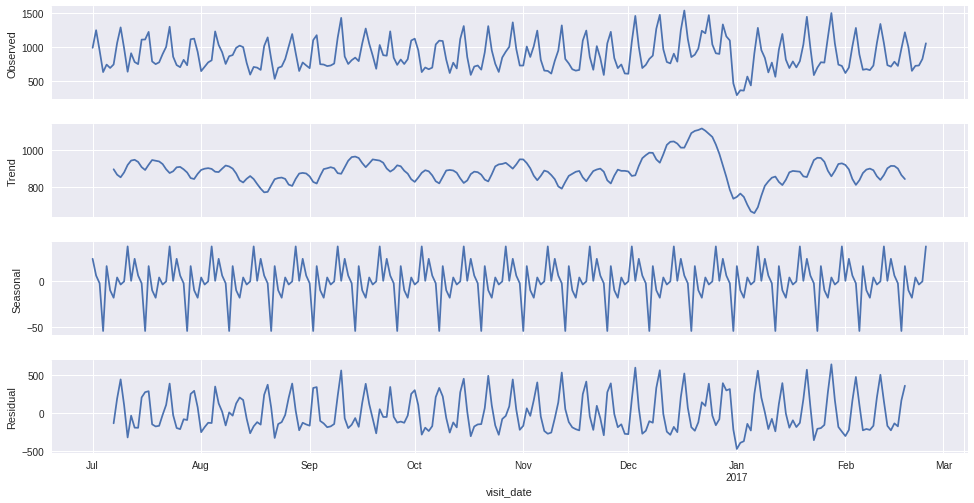

In [0]:
fecha_desde = datetime.strptime( '2016 07 01', '%Y %m %d')
fecha_hasta = datetime.strptime( '2017 04 22', '%Y %m %d')
df_train_i=df_train.set_index(['visit_date'], inplace=False)

df_dec = df_train_i[(df_train_i.index >= fecha_desde) & (df_train_i.index <= fecha_hasta)]
# df_dec['visitors_log'] = df_dec.visitors.apply(lambda x: np.log(x) )
df_dec['visitors_dec'] = df_dec.visitors.apply(lambda x: x )

#calcula log(0)posible solución filtrando 0
df_dec = df_dec[df_dec['visitors']!=0]

df_dec_gb=df_dec.groupby(by = df_dec.index).agg({'visitors_dec': np.sum})
decomposition = seasonal_decompose( 
    df_dec_gb, 
    freq= 12)  

fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

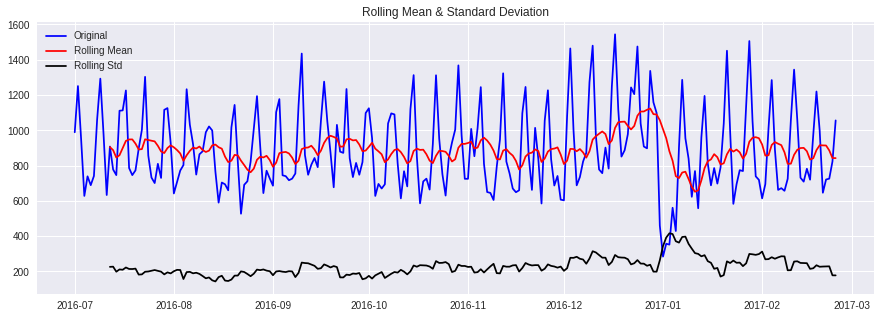

Results of Dickey-Fuller Test:
Test Statistic                 -3.744
p-value                         0.004
#Lags Used                     14.000
Number of Observations Used   224.000
Critical Value (1%)            -3.460
Critical Value (5%)            -2.875
Critical Value (10%)           -2.574
dtype: float64


AttributeError: ignored

In [0]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12,center=False).mean();
    rolstd = timeseries.rolling(window=12,center=False).std();

    #Plot rolling statistics:
    fig = plt.figure(figsize=(15, 5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    
test_stationarity(df_dec_gb.visitors_dec); #-3.796104
# Log is a minor improvement, meaning that the variance is stable
df_dec_gb.visitors_dec_log= df_dec_gb.visitors_dec.apply(lambda x: np.log(x))  
'''test_stationarity(df_dec_gb.visitors_dec_log) #-3.830754'''

# Although I see no real global trend, 1st difference strongly improves stationarity
df_dec_gb['visit_mean_diff'] = df_dec_gb.visitors_dec - df_dec_gb.visitors_dec.shift(1)  
test_stationarity(df_dec_gb.visitors_dec_diff.dropna(inplace=False)) #-6.608968e+00

# Seasonal difference: take a weekly season improves stationarity even more
df_dec_gb['visit_mean_seasonal'] = df_dec_gb.visitors_dec - df_dec_gb.visitors_dec.shift(7)
test_stationarity(df_dec_gb.visitors_dec_seasonal.dropna(inplace=False)) #-7.196314e+00

# Seasonal and 1st difference is even better, but we were already well within the 1% confidence interval
df_dec_gb['visit_mean_seasonal_diff'] = df_dec_gb.visitors_dec_diff - df_dec_gb.visitors_dec_diff.shift(7)
test_stationarity(df_dec_gb.visitors_dec_seasonal_diff.dropna(inplace=False)) #-9.427797e+00

## 5.b) XGBoost

## 5.c) Prophet (opcional)

## 5.d) LR (ponderador)

# 6.RESULTADOS

## 6.a) Scores

## 6.b) Gráficos